# 1. 밸류퀄리티 전략 지표들 들고 오기

In [323]:
import pandas as pd
import numpy as np

In [324]:
# 1) ts2000 3분기보고서 csv 가져오기
df_invest_연결= pd.read_csv('./data/KOSDAQ투자(연결).csv',encoding='CP949')
df_invest_개별 = pd.read_csv('./data/KOSDAQ투자(개별).csv',encoding='CP949')

In [325]:
# 2) 연결 재무제표 기준 개별 합치기
col = pd.Series(df_invest_연결.columns)

# 연결에 없는 값 개별에 있으면 대입
for i in range(len(col)):
        df_invest_연결.loc[df_invest_연결[col[i]].isna(), col[i]] = df_invest_개별[col[i]]

In [326]:
# 3) 거래소 코드 zfill
df_invest_연결['거래소코드'] = df_invest_연결['거래소코드'].astype('str')
df_invest_연결['거래소코드'] = df_invest_연결['거래소코드'].str.zfill(6)
# 4) 거래소코드가 2개 이상인거 확인
daq = df_invest_연결.groupby(['회사명'])['거래소코드'].nunique().reset_index()
daq[daq['거래소코드']>1]

회사명  거래소코드
1269  (주)핸디소프트      2

In [327]:
# 4) 삭제
df_invest_연결.drop(df_invest_연결[df_invest_연결['거래소코드']=='032380'].index,inplace=True)
df_invest_연결.reset_index(drop=True,inplace=True)
# 5) 회계년도 정리
df_invest_연결['회계년도'] = pd.to_datetime(df_invest_연결['회계년도'],format='%Y/%M')
df_invest_연결['회계년도'] = df_invest_연결['회계년도'].dt.year
df_invest_연결 = df_invest_연결[~(df_invest_연결['회계년도']==2009)]
df_invest_연결.reset_index(drop=True,inplace=True)

In [328]:
# 6) ts2000에서 결산월 종가 가져오기
price = pd.read_csv('./data/종가_주식수.csv',encoding='CP949')
price['회계년도'] = pd.to_datetime(price['회계년도'],format='%Y/%m')
price['회계년도'] = price['회계년도'].dt.year
price['거래소코드'] = price['거래소코드'].astype('str').str.zfill(6)
price = price[~(price['회계년도']==2009)]
price.reset_index(drop=True,inplace=True)

1. 보통주

In [329]:
price_1 = price.copy()

In [330]:
# 7) 주식 종류가 10이 아닌 인덱스 삭제
drop_index = price_1[~(price_1['주식의종류']==10.0)].index
price_1.drop(drop_index,inplace=True)
price_1.drop(['주식의종류'],axis=1,inplace=True)
price_1.reset_index(drop=True,inplace=True)
price_1.dropna(subset=['종가'],inplace=True)  # 종가가 없는 기타법인 삭제
# 기타법인, 코스닥 둘다 존재하는 거래소 2개인 기업 삭제 확인
daq_1 = price_1.groupby(['회사명'])['거래소코드'].nunique().reset_index()
daq_1[daq_1['거래소코드']>1]

Empty DataFrame
Columns: [회사명, 거래소코드]
Index: []

In [337]:
# 8) 데이터프레임 -> 주가,발행주식의 총수
df = df_invest_연결.merge(price_1,on=['회사명','거래소코드','회계년도'],how='left')
# 9) 4개 미만 즉 회사명, 거래소코드, 회계년도만 존재하는 행 삭제
df.dropna(subset=['자산'],inplace=True)
# 10) 종가가 없는 데이터 삭제
df.dropna(subset=['종가'],inplace=True)

In [338]:
df.isna().sum()

회사명             0
거래소코드           0
회계년도            0
자산              0
유동자산            0
현금및현금성자산        0
부채              0
유동부채            0
매출액             0
장기차입금           0
단기차입금           0
당기순이익           0
영업활동으로인한현금흐름    0
법인세비용차감전순이익     0
매출원가            0
자본              0
종가              0
발행주식의총수         0
dtype: int64

2. 우선주

In [339]:
price_2 = price.copy()

In [340]:
# 11) 주식 종류가 10이 아닌 인덱스 삭제
drop_index = price_2[~(price_2['주식의종류']==20.0)].index
price_2.drop(drop_index,inplace=True)
price_2.drop(['주식의종류'],axis=1,inplace=True)
price_2.reset_index(drop=True,inplace=True)
price_2.dropna(subset=['종가'],inplace=True)  # 종가가 없는 기타법인 삭제
# 기타법인, 코스닥 둘다 존재하는 거래소 2개인 기업 삭제 확인
daq_2 = price_2.groupby(['회사명'])['거래소코드'].nunique().reset_index()
daq_2[daq_2['거래소코드']>1]

Empty DataFrame
Columns: [회사명, 거래소코드]
Index: []

In [341]:
# 12) 데이터프레임 -> 주가,발행주식의 총수
df_plus = df.merge(price_2,on=['거래소코드','회계년도','회사명'],how='left',suffixes=('_보통주', '_우선주'))
# 13) 우선주가 없는 값은 0으로 채우기
df_plus[['종가_우선주','발행주식의총수_우선주']] = df_plus[['종가_우선주','발행주식의총수_우선주']].fillna(0)
# 14) 4개 미만 즉 회사명, 거래소코드, 회계년도만 존재하는 행 삭제
df_plus.dropna(subset=['자산'],inplace=True)
# 15) 종가가 없는 데이터 삭제
df_plus.dropna(subset=['종가_우선주'],inplace=True)

In [342]:
df_plus

회사명   거래소코드  회계년도          자산        유동자산    현금및현금성자산          부채  \
0      (주)CMG제약  058820  2010  23456619.0   9965208.0    231258.0  15723286.0   
1      (주)CMG제약  058820  2011  29477750.0  14760027.0    485657.0   9461282.0   
2      (주)CMG제약  058820  2012  45515723.0  33764182.0  20297395.0  29843038.0   
3      (주)CMG제약  058820  2013  56997644.0  40742605.0   3904337.0   7997418.0   
4      (주)CMG제약  058820  2014  57646794.0  28706417.0   9546923.0   8398498.0   
...         ...     ...   ...         ...         ...         ...         ...   
13413   흥구석유(주)  024060  2017  79097665.0  14997406.0   1217866.0  10285654.0   
13414   흥구석유(주)  024060  2018  77001426.0  12707368.0   1352394.0   7865391.0   
13415   흥구석유(주)  024060  2019  82746159.0  21832487.0   3134080.0   6572966.0   
13416   흥구석유(주)  024060  2020  81242681.0  25107354.0   3781715.0   5596818.0   
13417   흥구석유(주)  024060  2021  82019894.0  25936326.0    416730.0   3966430.0   

             유동부채          매출액      장기차입금      단기차입금      당기순이익  영업활동으로인한현금흐름  \
0      11171584.0    7980566.0    46200.0   551000.0 -4187367.0    -1388441.0   
1       6389723.0   12276653.0  2000000.0        0.0   572373.0     -676550.0   
2       7957865.0   12368445.0        0.0        0.0 -3363708.0    -1768573.0   
3       6429361.0   15186027.0        0.0     6885.0   541688.0    -3640506.0   
4       6791334.0   16988678.0        0.0     4443.0   266439.0       93111.0   
...           ...          ...        ...        ...        ...           ...   
13413   8794538.0  114790774.0        0.0  1000000.0  1068185.0     1163482.0   
13414   6662585.0  124658088.0        0.0  3000000.0   991365.0     -289684.0   
13415   4864599.0  109965869.0        0.0        0.0  7475822.0     1238029.0   
13416   3478232.0   84326655.0        0.0        0.0   825726.0     3685255.0   
13417   2346979.0   97117271.0        0.0        0.0   634402.0    -1062922.0   

       법인세비용차감전순이익         매출원가          자본  종가_보통주  발행주식의총수_보통주  종가_우선주  \
0       -4187367.0    6256318.0   7733334.0   792.0   41176375.0     0.0   
1         572373.0    6956005.0  20016467.0   785.0   43693200.0     0.0   
2       -3363708.0    8503073.0  15672685.0  1330.0   66025540.0     0.0   
3         571839.0    8891822.0  49000225.0   932.0   86626866.0     0.0   
4         266439.0   10585133.0  49248296.0   912.0   86626866.0   912.0   
...            ...          ...         ...     ...          ...     ...   
13413    1348425.0  109160672.0  68812011.0  2775.0   15000000.0     0.0   
13414    1242949.0  119084430.0  69136035.0  2705.0   15000000.0     0.0   
13415    9872838.0  104126869.0  76173193.0  5360.0   15000000.0     0.0   
13416    1053674.0   79807711.0  75645863.0  7220.0   15000000.0     0.0   
13417     792602.0   92460095.0  78053464.0  7160.0   15000000.0     0.0   

       발행주식의총수_우선주  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
13413          0.0  
13414          0.0  
13415          0.0  
13416          0.0  
13417          0.0  

[13418 rows x 20 columns]

# 2. 상대가치지표 계산

## 2-1. value 지표

In [343]:
# 1) PER = (종가*발행주식의총수) / 당기순이익
df_plus['PER'] = ((df_plus['종가_보통주'] * (df_plus['발행주식의총수_보통주']+df_plus.groupby('거래소코드')['발행주식의총수_보통주'].shift(1))/2)+(df_plus['종가_우선주'] * (df_plus['발행주식의총수_우선주']+df_plus.groupby('거래소코드')['발행주식의총수_우선주'].shift(1))/2)) / df_plus['당기순이익'] / 1000
# 2) PBR = (종가*발행주식의총수) / (자산-부채)
df_plus['PBR'] = ((df_plus['종가_보통주'] * df_plus['발행주식의총수_보통주'])+(df_plus['종가_우선주'] * df_plus['발행주식의총수_우선주'])) / (df_plus['자산'] - df_plus['부채'])  / 1000
# 3) PSR = (종가*발행주식의총수) / 매출액
df_plus['PSR'] = ((df_plus['종가_보통주'] * (df_plus['발행주식의총수_보통주']+df_plus.groupby('거래소코드')['발행주식의총수_보통주'].shift(1))/2)+(df_plus['종가_우선주'] * (df_plus['발행주식의총수_우선주']+df_plus.groupby('거래소코드')['발행주식의총수_우선주'].shift(1))/2)) / df_plus['매출액'] / 1000
# 4) PCR = (종가*발행주식의총수) / 영업활동으로인한현금흐름
df_plus['PCR'] = ((df_plus['종가_보통주'] * (df_plus['발행주식의총수_보통주']+df_plus.groupby('거래소코드')['발행주식의총수_보통주'].shift(1))/2)+(df_plus['종가_우선주'] * (df_plus['발행주식의총수_우선주']+df_plus.groupby('거래소코드')['발행주식의총수_우선주'].shift(1))/2)) / df_plus['영업활동으로인한현금흐름'] / 1000
# 5) EV/EBITDA = ((종가*발행주식의총수) + (장기차입금+단기차입금) - 현금및현금성자산) / 법인세비용차감전순이익
df_plus['EV/EBITDA'] = ((df_plus['종가_보통주'] * df_plus['발행주식의총수_보통주'])+(df_plus['종가_우선주'] * df_plus['발행주식의총수_우선주']) + (df_plus['장기차입금'] + df_plus['단기차입금'] - df_plus['현금및현금성자산'])) / df_plus['법인세비용차감전순이익'] / 1000

## 2-2 퀄리티 지표 계산

In [344]:
# 1) F_ROA = (연초총자산)조정 당기순이익 > 0
df_plus['F_ROA'] = df_plus['당기순이익'] > 0
# 2) F_CFO = (연초총자산)조정 영업활동으로인한현금흐름 > 0
df_plus['F_CFO'] = df_plus['영업활동으로인한현금흐름'] > 0
# 3) F_ΔROA = 전년 대비 ROA 증가
df_plus['F_ROA변화율'] = (df_plus['당기순이익']/df_plus['자산']) > (df_plus.groupby('거래소코드')['당기순이익'].shift(1)/df_plus.groupby('거래소코드')['자산'].shift(1))
# 4) F_ACCURUAL = 조정 영업현금 흐름 > 조정 당기순이익
df_plus['F_ACCURUAL'] = df_plus['영업활동으로인한현금흐름'] > df_plus['당기순이익']
# 5) F_ΔMARGIN = 전년 대비 매출총이익률(gross margin) 증가
df_plus['F_MARGIN변화율'] = ((df_plus['매출액']-df_plus['매출원가'])/df_plus['매출액']) > ((df_plus.groupby('거래소코드')['매출액'].shift(1) - df_plus.groupby('거래소코드')['매출원가'].shift(1)) / df_plus.groupby('거래소코드')['매출액'].shift(1))
# 6) F_ΔLEVER = 전년 대비 부채비율 감소
df_plus['F_LEVER변화율'] = (df_plus['부채']/df_plus['자본']) < (df_plus.groupby('거래소코드')['부채'].shift(1) / df_plus.groupby('거래소코드')['자본'].shift(1))
# 7) F_ΔLIQUID = 젼년 대비 유동비율 증가
df_plus['F_LIQUID변화율'] = (df_plus['유동자산']/df_plus['유동부채']) > (df_plus.groupby('거래소코드')['유동자산'].shift(1)/df_plus.groupby('거래소코드')['유동부채'].shift(1))
# 8) F_EQ_OFFER = 금년 신주발행(유무상증자) 여부
df_plus['F_EQ_OFFER'] = (df_plus.groupby('거래소코드')['발행주식의총수_보통주'].shift(1)+df_plus.groupby('거래소코드')['발행주식의총수_우선주'].shift(1)) != (df_plus['발행주식의총수_보통주']+df_plus['발행주식의총수_우선주'])
# 9) F_ΔTURN = 전년 대비 자산 회전율 증가
df_plus['F_TURN변화율'] = (df_plus['매출액']/df_plus['자산']) > (df_plus.groupby('거래소코드')['매출액'].shift(1)/df_plus.groupby('거래소코드')['자산'].shift(1))

## 2-3 사이즈 지표 계산

In [345]:
# 소형주 계산
df_plus['시가총액'] = (df_plus['종가_보통주'] * df_plus['발행주식의총수_보통주'])+(df_plus['종가_우선주'] * df_plus['발행주식의총수_우선주'])

## 2-4 전처리
> 1) 파생변수가 na -> 전년도 재무데이터가 없는 경우(첫번째 회계년도 ex) 2010년)이므로 삭제
> 2) value 지표들 음수면 nan으로 만들기
> 3) inf값 -> nan

In [351]:
# 1) 파생변수, 12/31 종가 데이터만 재 df화하기
df_value = pd.concat([df_plus.iloc[:,:3],df_plus.iloc[:,-14:]],axis=1)
# 2) 파생변수가 na -> 전년도 재무데이터가 없는 경우
df_value.dropna(axis=0, inplace=True)
df_value.reset_index(drop=True, inplace=True)
# 3) value 지표들 음수면 nan으로 만들기
df_value.loc[df_value['PER'] <= 0.2,'PER'] = np.NaN
df_value.loc[df_value['PBR'] <= 0.2,'PBR'] = np.NaN
df_value.loc[df_value['PSR'] <= 0.2,'PSR'] = np.NaN
df_value.loc[df_value['PCR'] <= 0.2,'PCR'] = np.NaN
df_value.loc[df_value['EV/EBITDA'] < 0,'EV/EBITDA'] = np.NaN
# 4) inf값 -> nan
df_value.replace(np.inf, np.NaN, inplace=True)
# 5) max값 삭제

In [352]:
df_value

회사명   거래소코드  회계년도         PER       PBR       PSR         PCR  \
0      (주)CMG제약  058820  2011   58.198602  1.713547  2.713387         NaN   
1      (주)CMG제약  058820  2012         NaN  5.602995  5.899122         NaN   
2      (주)CMG제약  058820  2013  131.322867  1.647671  4.684308         NaN   
3      (주)CMG제약  058820  2014  296.517033  1.604192  4.650374  848.489457   
4      (주)CMG제약  058820  2015         NaN  3.723576  9.403402  133.312820   
...         ...     ...   ...         ...       ...       ...         ...   
11743   흥구석유(주)  024060  2017   38.967969  0.604909  0.362616   35.776230   
11744   흥구석유(주)  024060  2018   40.928417  0.586886  0.325490         NaN   
11745   흥구석유(주)  024060  2019   10.754670  1.055489  0.731136   64.941936   
11746   흥구석유(주)  024060  2020  131.157309  1.431671  1.284291   29.387383   
11747   흥구석유(주)  024060  2021  169.293287  1.375980  1.105880         NaN   

        EV/EBITDA  F_ROA  F_CFO  F_ROA변화율  F_ACCURUAL  F_MARGIN변화율  \
0       59.927139   True  False      True       False         True   
1             NaN  False  False     False        True        False   
2      141.180195   True  False      True       False         True   
3      296.481218   True   True     False       False        False   
4             NaN  False   True     False        True        False   
...           ...    ...    ...       ...         ...          ...   
11743   30.869186   True   True     False        True        False   
11744   32.645465   True  False     False       False        False   
11745    8.143238   True   True      True       False         True   
11746  102.779625   True   True     False        True         True   
11747  135.502539   True  False     False       False        False   

       F_LEVER변화율  F_LIQUID변화율  F_EQ_OFFER  F_TURN변화율          시가총액  
0            True         True        True       True  3.429916e+10  
1           False         True        True      False  8.781397e+10  
2            True         True        True      False  8.073624e+10  
3           False        False       False       True  7.900370e+10  
4            True        False        True       True  1.863072e+11  
...           ...          ...         ...        ...           ...  
11743        True        False       False       True  4.162500e+10  
11744        True         True       False       True  4.057500e+10  
11745        True         True       False      False  8.040000e+10  
11746        True         True       False      False  1.083000e+11  
11747        True         True       False       True  1.074000e+11  

[11748 rows x 18 columns]

In [353]:
df_value.isna().sum()

회사명               0
거래소코드             0
회계년도              0
PER            4009
PBR              20
PSR               9
PCR            4356
EV/EBITDA      3935
F_ROA             0
F_CFO             0
F_ROA변화율          0
F_ACCURUAL        0
F_MARGIN변화율       0
F_LEVER변화율        0
F_LIQUID변화율       0
F_EQ_OFFER        0
F_TURN변화율         0
시가총액              0
dtype: int64

In [357]:
df_value.to_csv('./data/상대가치지표_2.csv')

# 3. Model Portfolio

## 3-1. 데이터 가져오기

In [355]:
import pandas as pd

In [553]:
# 1) 데이터 불러오고 연도,거래소코드 전처리
df = pd.read_csv('./data/상대가치지표_2.csv',index_col=0)
df['회계년도'] = pd.to_datetime(df['회계년도'],format='%Y')
df['회계년도'] = df['회계년도'].dt.year
df['거래소코드'] = df['거래소코드'].astype('str').str.zfill(6)
# 2) df_value_ / df_quality_ 데이터 프레임 나누기
df_value_ = df.iloc[:,1:8]
df_quality_ = pd.concat([df.iloc[:,1:3],df.iloc[:,8:17]],axis=1)
df_size = pd.concat([df.iloc[:,1:3],df.iloc[:,-1]],axis=1)
df_size.index = df_size['거래소코드']
df_size.drop('거래소코드',axis=1,inplace=True)

In [367]:
# 3) value,quality df 만들기
df_value = df_value_.pivot(index='거래소코드',columns='회계년도',values=['PER','PBR','PSR','PCR','EV/EBITDA'])
df_value = df_value.swaplevel(i=1, j=0, axis=1)
df_quality = df_quality_.pivot(index='거래소코드',columns='회계년도',values=['F_ROA','F_CFO','F_ROA변화율','F_ACCURUAL','F_MARGIN변화율','F_LEVER변화율','F_LIQUID변화율','F_EQ_OFFER','F_TURN변화율'])
df_quality = df_quality.swaplevel(i=1, j=0, axis=1)

In [498]:
df_value_.describe()

회계년도            PER           PBR           PSR            PCR  \
count  11748.000000    7739.000000  11728.000000  1.173900e+04    7392.000000   
mean    2016.432159     236.722130      2.402972  1.459772e+02     116.042642   
std        3.169201   11247.489245     14.700486  1.460557e+04    3332.560199   
min     2011.000000       0.229108      0.000000  2.358367e-02       0.149455   
25%     2014.000000      12.183080      0.818586  7.167309e-01       7.823763   
50%     2017.000000      20.900572      1.369701  1.534192e+00      15.456446   
75%     2019.000000      44.291199      2.399420  3.361236e+00      34.954651   
max     2021.000000  985255.923871   1507.387010  1.582275e+06  269713.370607   

           EV/EBITDA  
count    7813.000000  
mean       98.058795  
std      1530.816937  
min         0.000536  
25%        10.266903  
50%        17.661690  
75%        37.998418  
max    121117.713156

In [495]:
df_value.describe()

회계년도           2011          2012         2013         2014         2015  \
                PER           PER          PER          PER          PER   
count    606.000000    658.000000   625.000000   603.000000   659.000000   
mean     184.812086    124.717400    53.705958    61.938514    76.206448   
std     2466.834539   1234.878748   171.838630   326.784894   237.675038   
min        1.499684      1.967258     1.423755     1.157847     0.325091   
25%        9.525089     10.863877    10.944527    12.584377    14.130956   
50%       16.270491     17.457329    17.737038    19.913592    23.859774   
75%       33.603122     32.652665    36.184119    38.132676    54.943051   
max    57423.173804  28254.278729  2816.380332  7209.967296  2770.606845   

회계년도           2016          2017         2018          2019           2020  \
                PER           PER          PER           PER            PER   
count    696.000000    718.000000   750.000000    772.000000     755.000000   
mean     145.406372    195.821219    99.037315     78.827023    1399.804585   
std     1114.275862   1565.616732   616.660250    700.521110   35856.493405   
min        0.695636      0.229108     0.930953      1.033330       0.482315   
25%       15.679984     13.136854    10.266588     11.806397      14.837754   
50%       26.871562     21.528691    18.776386     21.058146      25.622601   
75%       55.681781     43.225221    42.396652     46.515019      56.950097   
max    26573.684717  31976.564949  9943.277216  19106.102993  985255.923871   

회계년도   ...         2012          2013         2014         2015          2016  \
       ...    EV/EBITDA     EV/EBITDA    EV/EBITDA    EV/EBITDA     EV/EBITDA   
count  ...   663.000000    630.000000   606.000000   671.000000    700.000000   
mean   ...    78.203250     58.036697    59.708100    77.547854    109.739760   
std    ...   409.528350    490.047878   305.346991   247.910083    625.192952   
min    ...     1.410929      1.314999     0.946366     0.608828      1.055365   
25%    ...     9.244976      9.291924    10.333354    11.649917     12.499544   
50%    ...    14.895687     14.362983    16.854898    19.997843     22.674730   
75%    ...    30.100095     29.086598    33.474865    45.290235     47.951069   
max    ...  6828.952314  12142.812129  6265.999847  2816.176105  10904.953500   

회계년도            2017         2018          2019          2020          2021  
           EV/EBITDA    EV/EBITDA     EV/EBITDA     EV/EBITDA     EV/EBITDA  
count     725.000000   756.000000    777.000000    773.000000    904.000000  
mean      240.146261    67.195081     99.055917    123.890730     90.031561  
std      4502.328618   304.535356   1157.728739   1340.830992    670.729900  
min         0.823292     0.853088      0.737412      0.623018      0.320673  
25%        10.802669     8.947144      9.927847     12.300933     10.629032  
50%        18.510876    15.847009     17.491158     22.149545     18.843532  
75%        39.003724    34.644647     37.629277     52.842360     40.612990  
max    121117.713156  4568.473663  31780.820685  36709.301746  14765.900092  

[8 rows x 55 columns]

In [368]:
# 4) 수정 종가 df 만들기
price = pd.read_csv('./data/kosdaq_price2.csv',index_col='날짜')
price.index = pd.to_datetime(price.index, infer_datetime_format=True)
price.columns = price.columns.astype('str').str.zfill(6)
price = price.fillna(0)
# price 데이터 중 재무제표 있는 데이터만 가져오기
price_1 = price.loc[:,df_value.index]
price_1

거래소코드       000250  000440  001000  001540  001810  001840  002230  002290  \
날짜                                                                           
2012-01-02    2355    3320     948    6565    1875    2376    3845    1335   
2012-01-03    2430    3330     964    6650    1870    2384    4200    1335   
2012-01-04    2475    3400     962    6718    1870    2340    4190    1330   
2012-01-05    2660    3350     952    6948    1850    2292    4150    1330   
2012-01-06    2635    3360     922    6929    1820    2320    3890    1400   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2021-12-27   42550   16750    2205   10900    3190    5840    4965    4270   
2021-12-28   43400   17450    2215   10900    3155    5830    5200    4280   
2021-12-29   44200   18000    2220   10900    3210    5840    5180    4285   
2021-12-30   43350   17550    2255   10700    3205    5920    5130    4290   
2022-01-03   44900   17200    2265   10750    3245    6010    5120    4410   

거래소코드       002670  002680  ...  900310  900340  950110   950130  950140  \
날짜                          ...                                            
2012-01-02   203.0    3757  ...     0.0     0.0     0.0      0.0     0.0   
2012-01-03   206.0    3935  ...     0.0     0.0     0.0      0.0     0.0   
2012-01-04   208.0    3861  ...     0.0     0.0     0.0      0.0     0.0   
2012-01-05   215.0    3728  ...     0.0     0.0     0.0      0.0     0.0   
2012-01-06   216.0    3911  ...     0.0     0.0     0.0      0.0     0.0   
...            ...     ...  ...     ...     ...     ...      ...     ...   
2021-12-27     0.0    1239  ...  1385.0  1120.0  6440.0  15800.0  8870.0   
2021-12-28     0.0    1234  ...  1380.0  1160.0  6520.0  15300.0  8720.0   
2021-12-29     0.0    1239  ...  1405.0  1135.0  6770.0  15600.0  8500.0   
2021-12-30     0.0    1244  ...  1410.0  1125.0  6880.0  16000.0  8600.0   
2022-01-03     0.0    1254  ...  1530.0  1215.0  7080.0  16450.0  8310.0   

거래소코드       950160  950170   950180   950190  950200  
날짜                                                    
2012-01-02     0.0     0.0      0.0      0.0     0.0  
2012-01-03     0.0     0.0      0.0      0.0     0.0  
2012-01-04     0.0     0.0      0.0      0.0     0.0  
2012-01-05     0.0     0.0      0.0      0.0     0.0  
2012-01-06     0.0     0.0      0.0      0.0     0.0  
...            ...     ...      ...      ...     ...  
2021-12-27  8010.0  3890.0  35850.0  23700.0  8760.0  
2021-12-28  8010.0  3935.0  35800.0  23550.0  8780.0  
2021-12-29  8010.0  4055.0  35950.0  22900.0  8910.0  
2021-12-30  8010.0  4080.0  36050.0  23450.0  8890.0  
2022-01-03  8010.0  4045.0  36000.0  22800.0  8880.0  

[2464 rows x 1522 columns]

In [473]:
# 5) 모멘텀, low vol에 쓰일수정 종가 df 만들기
price2 = pd.read_csv('./data/kosdaq_price4.csv',index_col='날짜')
price2.index = pd.to_datetime(price2.index, infer_datetime_format=True)
price2.columns = price2.columns.astype('str').str.zfill(6)
## price_2 데이터 중 재무제표 있는 데이터만 가져오기
price_2 = price2.loc[:,df_value.index]
price_2

거래소코드       000250  000440  001000  001540  001810  001840  002230  002290  \
날짜                                                                           
2010-12-29    2160    3494     861    5695    2510    4320    4130    1730   
2010-12-30    2140    3544     860    5733    2500    4464    4215    1685   
2011-01-03    2135    3624     837    5733    2485    4449    4250    1660   
2011-01-04    2150    3654     861    5715    2480    4400    4250    1660   
2011-01-05    2140    3880     864    5715    2475    4313    4410    1675   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2021-12-27   42550   16750    2205   10900    3190    5840    4965    4270   
2021-12-28   43400   17450    2215   10900    3155    5830    5200    4280   
2021-12-29   44200   18000    2220   10900    3210    5840    5180    4285   
2021-12-30   43350   17550    2255   10700    3205    5920    5130    4290   
2022-01-03   44900   17200    2265   10750    3245    6010    5120    4410   

거래소코드       002670  002680  ...  900310  900340  950110   950130  950140  \
날짜                          ...                                            
2010-12-29   307.0    2424  ...     NaN     NaN     NaN      NaN     NaN   
2010-12-30   307.0    2424  ...     NaN     NaN     NaN      NaN     NaN   
2011-01-03   314.0    2469  ...     NaN     NaN     NaN      NaN     NaN   
2011-01-04   310.0    2839  ...     NaN     NaN     NaN      NaN     NaN   
2011-01-05   307.0    2874  ...     NaN     NaN     NaN      NaN     NaN   
...            ...     ...  ...     ...     ...     ...      ...     ...   
2021-12-27     NaN    1239  ...  1385.0  1120.0  6440.0  15800.0  8870.0   
2021-12-28     NaN    1234  ...  1380.0  1160.0  6520.0  15300.0  8720.0   
2021-12-29     NaN    1239  ...  1405.0  1135.0  6770.0  15600.0  8500.0   
2021-12-30     NaN    1244  ...  1410.0  1125.0  6880.0  16000.0  8600.0   
2022-01-03     NaN    1254  ...  1530.0  1215.0  7080.0  16450.0  8310.0   

거래소코드       950160  950170   950180   950190  950200  
날짜                                                    
2010-12-29     NaN     NaN      NaN      NaN     NaN  
2010-12-30     NaN     NaN      NaN      NaN     NaN  
2011-01-03     NaN     NaN      NaN      NaN     NaN  
2011-01-04     NaN     NaN      NaN      NaN     NaN  
2011-01-05     NaN     NaN      NaN      NaN     NaN  
...            ...     ...      ...      ...     ...  
2021-12-27  8010.0  3890.0  35850.0  23700.0  8760.0  
2021-12-28  8010.0  3935.0  35800.0  23550.0  8780.0  
2021-12-29  8010.0  4055.0  35950.0  22900.0  8910.0  
2021-12-30  8010.0  4080.0  36050.0  23450.0  8890.0  
2022-01-03  8010.0  4045.0  36000.0  22800.0  8880.0  

[2714 rows x 1522 columns]

## 3-2 VALUE & 관리종목예측모델 X -(1)

In [7]:
# 1) multimetrix 지표 조합 함수
## 1-1) 저평가 지수를 기준으로 정렬하여 순위 만들어 주는 함수
def get_value_rank(invest_df, value_type, index_date, num): # (dataframe,지표,날짜,순위)
    invest_df[(index_date,  value_type)] = pd.to_numeric(invest_df[(index_date,  value_type)])
    value_sorted = invest_df.sort_values(by=(index_date,  value_type))[index_date]
    value_sorted[value_type + '순위'] = value_sorted[value_type].rank() # default : ascending=True(오름차순)
    return value_sorted[[value_type, value_type + '순위']][:num]

## 1-2) 저평가 지수 multi-metrix
def make_value_multi(invest_df, value_list, index_date, num):
    for i, value in enumerate(value_list):
        temp_df = get_value_rank(invest_df, value, index_date, None)
        if i == 0:
            value_combo_df = temp_df
            rank_combo = temp_df[value + '순위']
        else:
            value_combo_df = pd.merge(value_combo_df, temp_df, how='outer', left_index=True, right_index=True)
            rank_combo = rank_combo + temp_df[value + '순위']

    value_combo_df['종합순위'] = rank_combo.rank()
    value_combo_df = value_combo_df.sort_values(by='종합순위')

    return value_combo_df[:num]

## 3-3 Value & 관리종목예측모델 O - (2)

In [8]:
# 1) 관리종목 실제, 예측값 데이터 프레임 가져오기
predict = pd.read_csv('./data/실제_예측.csv',index_col=0)
predict['회계년도'] = pd.to_datetime(predict['회계년도'],format='%Y')
predict['회계년도'] = predict['회계년도'].dt.year
predict['거래소코드'] = predict['거래소코드'].astype('str').str.zfill(6)
predict

거래소코드  회계년도    y   예측
0      058820  2011  0.0  0.0
1      058820  2012  0.0  1.0
2      058820  2013  0.0  0.0
3      058820  2014  0.0  0.0
4      058820  2015  0.0  0.0
...       ...   ...  ...  ...
10654  024060  2016  0.0  0.0
10655  024060  2017  0.0  0.0
10656  024060  2018  0.0  1.0
10657  024060  2019  0.0  0.0
10658  024060  2020  0.0  1.0

[10659 rows x 4 columns]

In [9]:
# 2) real, predict 관리종목인 거래소코드 집합 가져오기
## ex) 2011년 데이터를 바탕으로 2012년 관리종목을 예측하고 실제 관리종목인 애들의 거래소코드를 가져오기
for i in predict['회계년도'].unique():
    globals()['real__{}'.format(i+1)] = set(predict.loc[(predict['회계년도']==i)&(predict['y']==1),'거래소코드'])
    globals()['predict__{}'.format(i+1)] = set(predict.loc[(predict['회계년도']==i)&(predict['예측']==1),'거래소코드'])

In [10]:
# 3) set(실제 관리종목).union(관리종목으로 예측) 애들(가격데이터가 있는)의 거래소 코드를 data_df에서 빼버리기
def minus_predict(data_df, price_df, predict):
    # data_df에 따라서 빈 selected_df multi index 만들기
    idx = pd.MultiIndex.from_product([data_df.columns.get_level_values(0).unique().tolist()[1:], data_df.columns.get_level_values(1).unique().tolist()]).to_frame()
    selected_df = pd.DataFrame(columns=idx.index)
    minus_code = []
    # 2010년 
    for i in predict['회계년도'].unique():
        for code in price_df.loc[str(i+1)].loc[:,~(price_df.loc[str(i+1)].columns.isin(globals()['real__{}'.format(i+1)].union(globals()['predict__{}'.format(i+1)])))].columns:
            minus_code.append(code)
        minus_code = list(set(minus_code))
        selected_df[i+1] =  data_df[i+1].loc[minus_code]
    return selected_df

## 3-4 Quality & 관리종목예측모델 X - (3)

In [11]:
# 1-1) F-score 함수
def get_fscore(fs_df, index_date, score):
    # pd.set_option('chained', None)
    fscore_df = fs_df[index_date]
    fscore_df['종합점수'] = fscore_df[['F_ROA','F_CFO','F_ROA변화율','F_ACCURUAL','F_MARGIN변화율','F_LEVER변화율','F_LIQUID변화율','F_EQ_OFFER','F_TURN변화율']].sum(axis=1)
    fscore_df = fscore_df[fscore_df['종합점수'].isin(score)].sort_values(by='종합점수')
    return fscore_df

## 3-5 Quality & 관리종목예측모델 O - (4)

3-3 과 동일

## 3-6 Value & Quality & 관리종목예측모델 X - (5)

In [12]:
def get_value_quality(invest_df, fs_df, index_date, num, score):
    value = make_value_multi(invest_df,['PER','PBR','PSR','PCR','EV/EBITDA'], index_date, None)
    quality = get_fscore(fs_df, index_date,[0,1,2,3,4,5,6,7,8,9])
    value_quality = pd.merge(value, quality, how='outer', left_index=True, right_index=True)
    value_quality_filtered = value_quality[value_quality['종합점수'].isin(score)]
    vq_df = value_quality_filtered.sort_values(by='종합순위')
    return vq_df[:num]

## 3-7 Value & Quality & 관리종목예측모델 O - (6)

3-3 과 동일

## 3-8 상대 Momentum & 관리종목예측모델 X -(7)

In [13]:
def get_momentum_rank(price_df, index_date, date_range, num):
    momentum_df = pd.DataFrame(price_df.pct_change(date_range).loc[index_date])
    momentum_df = momentum_df.replace([np.inf, -np.inf], np.nan)
    momentum_df.columns = ['모멘텀']
    momentum_df['모멘텀순위'] = momentum_df['모멘텀'].rank(ascending=False)
    momentum_df = momentum_df.sort_values(by='모멘텀순위')
    return momentum_df[:num]

## 3-9 상대 Momentum & 관리종목예측모델 O -(8)

In [126]:
# set(실제 관리종목).union(관리종목으로 예측) 애들(가격데이터가 있는)의 거래소 코드를 price_df에서 빼버리기
def minus_predict_price(price_df, predict):
    price_df2 = price_df[:'2011-12']
    price_momentum = {}
    for i in predict['회계년도'].unique():
        price_momentum[str(i+1)] = price_df.loc[str(i+1)].loc[:,~(price_df.loc[str(i+1)].columns.isin(globals()['real__{}'.format(i+1)].union(globals()['predict__{}'.format(i+1)])))]
        price_df2 = pd.concat([price_df2,price_momentum[str(i+1)]],axis=0)
    return price_df2

## 3-10 low volatility & 관리종목예측모델 X - (9)

In [655]:
def get_lowvol_rank(price_df, year, date_range, num):
    minus_code =[]
    a = price_df.groupby(pd.Grouper(freq="MS")).first()
    for code in pd.DataFrame(a.pct_change().rolling(12).std().loc[year]).dropna(how='all',axis=1).T.index:
        minus_code.append(code)
    price_df =  price_df.loc[:,minus_code]
    lowvol_df = pd.DataFrame(a.pct_change().rolling(12).std().loc[year]).dropna(how='all',axis=1).T
    lowvol_df.columns = ['로우볼']
    lowvol_df = lowvol_df[lowvol_df['로우볼']>0.00000001]
    lowvol_df['로우볼순위'] = lowvol_df['로우볼'].rank(ascending=True)
    lowvol_df = lowvol_df.sort_values(by='로우볼순위')
    return lowvol_df[:num]

## 3-11 low volatility & 관리종목예측모델 O - (10)

3-9와 동일

## 3-12 dividend & 관리종목예측모델 X - (11)

In [ ]:
# 1) div 가져오기
div = pd.read_csv('./data/kosdaq_div.csv',index_col='날짜')
div.index = pd.to_datetime(div.index, infer_datetime_format=True)
div.columns = div.columns.astype('str').str.zfill(6)
## div 데이터 중 재무제표 있는 데이터만 가져오기
div.loc[:,div.columns.isin(df_value.index)]
div

In [17]:
# 2) div 순위 함수
def get_div_rank(invest_df, index_date, date_range):
    div_df = pd.DataFrame(invest_df.rolling(date_range).mean(skipna=True).loc[index_date])
    div_df.columns = ['배당']
    div_df = div_df[div_df['배당']>0]
    div_df['배당순위'] = div_df['배당'].rank(ascending=False)
    div_df = div_df.sort_values(by='배당순위')
    return div_df

## 3-13 size

In [443]:
def get_size_rank(invest_df, index_date, num): # (dataframe,지표,날짜,순위)
    value_sorted = invest_df[invest_df['회계년도']==index_date].sort_values(by='시가총액',ascending=False)['시가총액']
    value_sorted = pd.DataFrame(value_sorted)
    value_sorted['시가총액순위'] = value_sorted.rank(ascending=False) # default : ascending=True(오름차순)
    return value_sorted[['시가총액순위']][:num], value_sorted[['시가총액순위']][num:]

### 3-13-1 size 적용 함수 - value,quality df

In [582]:
# 1) value,quality에 들어가는 소형주 적용 함수
def add_size(data_df,size_df, price_df):
    # data_df에 따라서 빈 selected_df multi index 만들기
    idx = pd.MultiIndex.from_product([data_df.columns.get_level_values(0).unique().tolist(), data_df.columns.get_level_values(1).unique().tolist()]).to_frame()
    selected_df = pd.DataFrame(columns=idx.index)
    # 2010년 
    for i in range(2021,2011,-1):
        df_large,df_small = get_size_rank(size_df, i, 100)
        minus_code = price_df.loc[str(i)].loc[:,(price_df.loc[str(i)].columns.isin(set(df_small.index)))].columns
        selected_df[i] =  data_df[i].loc[minus_code]
    return selected_df

In [640]:
# 2) 예측 모델 적용
def size_minus_predict(data_df, size_df,price_df, predict):
    # data_df에 따라서 빈 selected_df multi index 만들기
    idx = pd.MultiIndex.from_product([data_df.columns.get_level_values(0).unique().tolist()[1:], data_df.columns.get_level_values(1).unique().tolist()]).to_frame()
    selected_df = pd.DataFrame(columns=idx.index)
    minus_code = []
    # 2010년 
    for i in range(2021,2011,-1):
        for code in price_df.loc[str(i)].loc[:,~(price_df.loc[str(i)].columns.isin(globals()['real__{}'.format(i)].union(globals()['predict__{}'.format(i)])))].columns:
            minus_code.append(code)
        minus_code_1 = set(minus_code)
        df_large,df_small = get_size_rank(size_df, i, 100)
        minus_code_2 = set(price_df.loc[str(i)].loc[:,(price_df.loc[str(i)].columns.isin(set(df_small.index)))].columns)
        cond = (minus_code_1)&(minus_code_2)
        selected_df[i] =  data_df[i].loc[cond]
    return selected_df

### 3-13-2 size 적용 함수 - momentum, low vol df

In [598]:
# 1) momentum, low vol에 들어가는 소형주 적용 함수
# set(실제 관리종목).union(관리종목으로 예측) 애들(가격데이터가 있는)의 거래소 코드를 price_df에서 빼버리기
def add_size_price(price_df, size_df):
    price_df2 = pd.DataFrame()
    price_momentum = {}
    for i in range(2022,2009,-1):
        price_momentum[str(i)] = price_df.loc[str(i)].loc[:,(price_df.loc[str(i)].columns.isin(set(size_df.index)))]
        price_df2 = pd.concat([price_df2,price_momentum[str(i)]],axis=0)
        price_df2 = price_df2.sort_values(by='날짜')
    #price_df2 = pd.concat([price_df2,price_df['2022']],axis=0)
    return price_df2

In [641]:
# 2) 예측모델 빼기
def size_minus_predict_price(price_df, size_df, predict):
    price_df2 = price_df[:'2011-12']
    price_momentum = {}
    for i in range(2021,2011,-1):
        minus_code_1 = ~(price_df.loc[str(i)].columns.isin(globals()['real__{}'.format(i)].union(globals()['predict__{}'.format(i)])))
        minus_code_2 = (price_df.loc[str(i)].columns.isin(set(size_df.index)))
        cond = (minus_code_1)&(minus_code_2)
        price_momentum[str(i)] = price_df.loc[str(i)].loc[:,cond]
        price_df2 = pd.concat([price_df2,price_momentum[str(i)]],axis=0)
        price_df2 = price_df2.sort_values(by='날짜')
    return price_df2

# 4 백테스팅

## 4-1 백테스팅 함수

### 4-1-1. 기본 백테스트 함수

In [68]:
# 백테스트 함수
def backtest_beta(price_df, strategy_df, start_date, end_date, initial_money):
    # 1) 전략에 해당하는 종목코드와 가격데이터 가져오기
    code_list = []
    for code in strategy_df.index:
        code_list.append(code)
    strategy_price = price_df[code_list][start_date:end_date]
    
    # 2) 각 종목마다 몇개씩 살지 계산하여 포트폴리오 구성 & 주식 포트폴리오의 변화 구하기
    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(strategy_df)
    for code in strategy_price.columns:
        strategy_price.fillna(1, inplace=True)  # 수정 code
        temp = int(each_money / strategy_price[code][0])
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]
    cash_amount = initial_money - stock_amount
    backtest_df = pd.DataFrame({'주식포트폴리오': stock_pf})
    backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
    backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
    backtest_df['일변화율'] = backtest_df['주식포트폴리오'].pct_change()
    backtest_df['총변화율'] = backtest_df['주식포트폴리오'] / initial_money - 1
    return backtest_df

### 4-1-2. 관리종목지정예측모델을 적용하기 전 백테스팅 함수(리밸런싱 1년)

In [245]:
# 리밸런싱 함수
def backtest_re(strategy, start_date, end_date, initial_money, price_df, fs_df, num=None, score=None, value_type=None,
                value_list=None, date_range=None):
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    total_df = 0
    # 백테스트 기간이 주어지면 리밸런싱 주기로 나누기
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp + 1) + '-' + start_date.split('-')[1]
        strategy_date = int(this_term_start.split('-')[0])
        # 전략 함수 이름에 따라 다른 전략 사용한 dataframe 가져오기
        if strategy.__name__ == 'get_value_rank':
            st_df = strategy(df_value, value_type, strategy_date, num)
        elif strategy.__name__ == 'make_value_multi':
            st_df = strategy(df_value,value_list, strategy_date, num)
        elif strategy.__name__ == 'get_fscore':
            st_df = strategy(fs_df, strategy_date, score)
        elif strategy.__name__ == 'get_value_quality':
            st_df = strategy(df_value, fs_df, strategy_date, num,score)
        elif strategy.__name__ == 'get_momentum_rank':
             st_df = strategy(price_df, price_df[this_term_start].index[0], date_range, num)
        elif strategy.__name__ == 'get_lowvol_rank':
            st_df = strategy(price_df, this_term_start, date_range, num)

        backtest = backtest_beta(price_df, st_df, this_term_start, this_term_end, initial_money)
        temp_end = backtest[this_term_end].index[0]
        backtest = backtest[:temp_end]
        initial_money = backtest['종합포트폴리오'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df[:-1], backtest])

    total_df['일변화율'] = total_df['주식포트폴리오'].pct_change()
    total_df['총변화율'] = total_df['주식포트폴리오'] / total_df['주식포트폴리오'][0] - 1

    return total_df

### 4-1-3. 관리종목지정예측모델을 적용한 백테스팅 코드(리밸런싱 1년)

In [246]:
# 관리종목 예측, 실제 빼는 백테스팅 코드
def backtest_re_minus_admin(strategy, start_date, end_date, initial_money, price_df, fs_df, num=None, score=None, value_type=None,
                value_list=None, date_range=None):
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    total_df = 0
    # 백테스트 기간이 주어지면 리밸런싱 주기로 나누기
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp + 1) + '-' + start_date.split('-')[1]
        strategy_date = int(this_term_start.split('-')[0])
        # minus_predict(dataframe,price_df,predict) 형식으로 dataframe 가져오기!
        if strategy.__name__ == 'get_value_rank':
            st_df = strategy(minus_predict(df_value,price_df,predict), value_type, strategy_date, num)
        elif strategy.__name__ == 'make_value_multi':
            st_df = strategy(minus_predict(df_value,price_df,predict),value_list, strategy_date, num)
        elif strategy.__name__ == 'get_fscore':
            st_df = strategy(minus_predict(fs_df,price_df,predict),strategy_date, score)
        elif strategy.__name__ == 'get_momentum_rank':
             st_df = strategy(minus_predict_price(price_df, predict), price_df[this_term_start].index[0], date_range, num)
        elif strategy.__name__ == 'get_value_quality':
            st_df = strategy(minus_predict(df_value,price_df,predict), minus_predict(fs_df,price_df,predict), strategy_date, num,score)
        elif strategy.__name__ == 'get_lowvol_rank':
            st_df = strategy(minus_predict_price(price_df, predict), this_term_start, date_range, num)
            
        backtest = backtest_beta(price_df, st_df, this_term_start, this_term_end, initial_money)
        temp_end = backtest[this_term_end].index[0]
        backtest = backtest[:temp_end]
        initial_money = backtest['종합포트폴리오'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df[:-1], backtest])

    total_df['일변화율'] = total_df['주식포트폴리오'].pct_change()
    total_df['총변화율'] = total_df['주식포트폴리오'] / total_df['주식포트폴리오'][0] - 1

    return total_df

### 4-1-4. size 적용 함수

In [600]:
# 리밸런싱 함수
def backtest_re_size(strategy, start_date, end_date, initial_money, price_df, fs_df,size_df, num=None, score=None, value_type=None,
                value_list=None, date_range=None):
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    total_df = 0
    # 백테스트 기간이 주어지면 리밸런싱 주기로 나누기
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp + 1) + '-' + start_date.split('-')[1]
        strategy_date = int(this_term_start.split('-')[0])
        # 전략 함수 이름에 따라 다른 전략 사용한 dataframe 가져오기
        if strategy.__name__ == 'get_value_rank':
            st_df = strategy(add_size(df_value,size_df, price_df), value_type, strategy_date, num)
        elif strategy.__name__ == 'make_value_multi':
            st_df = strategy(add_size(df_value,size_df, price_df),value_list, strategy_date, num)
        elif strategy.__name__ == 'get_fscore':
            st_df = strategy(add_size(fs_df,size_df, price_df), strategy_date, score)
        elif strategy.__name__ == 'get_value_quality':
            st_df = strategy(add_size(df_value,size_df, price_df), add_size(fs_df,size_df, price_df), strategy_date, num,score)
        elif strategy.__name__ == 'get_momentum_rank':
             st_df = strategy(add_size_price(price_df, size_df), add_size_price(price_df, size_df)[this_term_start].index[0], date_range, num)
        elif strategy.__name__ == 'get_lowvol_rank':
            st_df = strategy(add_size_price(price_df, size_df), this_term_start, date_range, num)

        backtest = backtest_beta(price_df, st_df, this_term_start, this_term_end, initial_money)
        temp_end = backtest[this_term_end].index[0]
        backtest = backtest[:temp_end]
        initial_money = backtest['종합포트폴리오'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df[:-1], backtest])

    total_df['일변화율'] = total_df['주식포트폴리오'].pct_change()
    total_df['총변화율'] = total_df['주식포트폴리오'] / total_df['주식포트폴리오'][0] - 1

    return total_df

In [625]:
# 관리종목 예측, 실제 빼는 백테스팅 코드
def backtest_re_size_minus_admin(strategy, start_date, end_date, initial_money, price_df, fs_df,size_df, num=None, score=None, value_type=None,
                value_list=None, date_range=None):
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    total_df = 0
    # 백테스트 기간이 주어지면 리밸런싱 주기로 나누기
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp + 1) + '-' + start_date.split('-')[1]
        strategy_date = int(this_term_start.split('-')[0])
        # minus_predict(dataframe,price_df,predict) 형식으로 dataframe 가져오기!
        if strategy.__name__ == 'get_value_rank':
            st_df = strategy(size_minus_predict(df_value, size_df,price_df, predict), value_type, strategy_date, num)
        elif strategy.__name__ == 'make_value_multi':
            st_df = strategy(size_minus_predict(df_value, size_df,price_df, predict),value_list, strategy_date, num)
        elif strategy.__name__ == 'get_fscore':
            st_df = strategy(size_minus_predict(fs_df, size_df,price_df, predict),strategy_date, score)
        elif strategy.__name__ == 'get_momentum_rank':
            st_df = strategy(size_minus_predict_price(price_df, size_df, predict), price_df[this_term_start].index[0], date_range, num)
        elif strategy.__name__ == 'get_value_quality':
            st_df = strategy(size_minus_predict(df_value, size_df,price_df, predict), size_minus_predict(fs_df, size_df,price_df, predict), strategy_date, num,score)
        elif strategy.__name__ == 'get_lowvol_rank':
            st_df = strategy(size_minus_predict_price(price_df, size_df, predict), this_term_start, date_range, num)
            
        backtest = backtest_beta(price_df, st_df, this_term_start, this_term_end, initial_money)
        temp_end = backtest[this_term_end].index[0]
        backtest = backtest[:temp_end]
        initial_money = backtest['종합포트폴리오'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df[:-1], backtest])

    total_df['일변화율'] = total_df['주식포트폴리오'].pct_change()
    total_df['총변화율'] = total_df['주식포트폴리오'] / total_df['주식포트폴리오'][0] - 1

    return total_df

## 4-2 백테스팅 결과 출력

In [21]:
score = [8,9]
num = 20
start_date = '2012-01'
end_date = '2022-01'
initial_money = 100000000

In [360]:
# 1) value 전략 & 예측모델 X
backtest_value_1 = backtest_re(make_value_multi, start_date, end_date, initial_money, price_1, fs_df = df_quality, num=20, value_list=['PER','PBR','PSR','PCR','EV/EBITDA'])
backtest_value_1
# 주식포트폴리오 == 20개의 종목을 선정하고, 1억을 투자했을 때 각 종목당 500만원씩 투자하게 됨
# 이 때, 한 주당 가격이 다르므로 한 종목당 500만원 선에서 최대한 구매한 주수의 가격들을 모두 합친것이 주식포트폴리오
# 주식을 사고 남은 현금이 현금포트폴리오가 된다.

C:\Users\user\AppData\Local\Temp/ipykernel_14056/3308491769.py:25: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오  현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                               
2012-01-02   99953133.0  46867.0  100000000.0       NaN  0.000000
2012-01-03  101122618.0  46867.0  101169485.0  0.011700  0.011700
2012-01-04  102989080.0  46867.0  103035947.0  0.018457  0.030374
2012-01-05  104984698.0  46867.0  105031565.0  0.019377  0.050339
2012-01-06  106041749.0  46867.0  106088616.0  0.010069  0.060915
...                 ...      ...          ...       ...       ...
2021-12-27  120162965.0  60468.0  120223433.0  0.004474  0.202193
2021-12-28  120847990.0  60468.0  120908458.0  0.005701  0.209047
2021-12-29  121065485.0  60468.0  121125953.0  0.001800  0.211223
2021-12-30  121841965.0  60468.0  121902433.0  0.006414  0.218991
2022-01-03  125219580.0  60468.0  125280048.0  0.027721  0.252783

[2464 rows x 5 columns]

In [603]:
# 2) value 전략 & 예측모델 O
backtest_value_2 = backtest_re_minus_admin(make_value_multi, start_date, end_date, initial_money, price_1, fs_df = df_quality, num=20, value_list=['PER','PBR','PSR','PCR','EV/EBITDA'])
backtest_value_2

C:\Users\user\AppData\Local\Temp/ipykernel_2080/3983806683.py:30: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오  현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                               
2012-01-02   99948740.0  51260.0  100000000.0       NaN  0.000000
2012-01-03  101239318.0  51260.0  101290578.0  0.012912  0.012912
2012-01-04  103045184.0  51260.0  103096444.0  0.017838  0.030980
2012-01-05  104971133.0  51260.0  105022393.0  0.018690  0.050250
2012-01-06  105510793.0  51260.0  105562053.0  0.005141  0.055649
...                 ...      ...          ...       ...       ...
2021-12-27  102431108.0  53058.0  102484166.0  0.003827  0.024836
2021-12-28  102747424.0  53058.0  102800482.0  0.003088  0.028001
2021-12-29  103055540.0  53058.0  103108598.0  0.002999  0.031084
2021-12-30  103549780.0  53058.0  103602838.0  0.004796  0.036029
2022-01-03  107406771.0  53058.0  107459829.0  0.037248  0.074619

[2464 rows x 5 columns]

In [602]:
# 3) value 전략 & 예측모델 X & 소형주
backtest_value_3 = backtest_re_size(make_value_multi, start_date, end_date, initial_money, price_1, fs_df = df_quality,size_df=df_size, num=20, value_list=['PER','PBR','PSR','PCR','EV/EBITDA'])
backtest_value_3

C:\Users\user\AppData\Local\Temp/ipykernel_2080/275097568.py:28: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오  현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                               
2012-01-02   99970799.0  29201.0  100000000.0       NaN  0.000000
2012-01-03  100847054.0  29201.0  100876255.0  0.008765  0.008765
2012-01-04  102490810.0  29201.0  102520011.0  0.016299  0.025207
2012-01-05  103867474.0  29201.0  103896675.0  0.013432  0.038978
2012-01-06  104541539.0  29201.0  104570740.0  0.006490  0.045721
...                 ...      ...          ...       ...       ...
2021-12-27  165014513.0  63478.0  165077991.0  0.004005  0.650627
2021-12-28  166156508.0  63478.0  166219986.0  0.006921  0.662050
2021-12-29  166506534.0  63478.0  166570012.0  0.002107  0.665552
2021-12-30  167606420.0  63478.0  167669898.0  0.006606  0.676554
2022-01-03  172924147.0  63478.0  172987625.0  0.031727  0.729747

[2464 rows x 5 columns]

In [621]:
# 4) value 전략 & 예측모델 O & 소형주
backtest_value_4 = backtest_re_size_minus_admin(make_value_multi, start_date, end_date, initial_money, price_1, fs_df = df_quality,size_df=df_size, num=20, value_list=['PER','PBR','PSR','PCR','EV/EBITDA'])
backtest_value_4

C:\Users\user\AppData\Local\Temp/ipykernel_2080/2536587895.py:33: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오  현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                               
2012-01-02   99953133.0  46867.0  100000000.0       NaN  0.000000
2012-01-03  101122618.0  46867.0  101169485.0  0.011700  0.011700
2012-01-04  102989080.0  46867.0  103035947.0  0.018457  0.030374
2012-01-05  104984698.0  46867.0  105031565.0  0.019377  0.050339
2012-01-06  106041749.0  46867.0  106088616.0  0.010069  0.060915
...                 ...      ...          ...       ...       ...
2021-12-27  137603715.0  58900.0  137662615.0  0.004472  0.376682
2021-12-28  138388440.0  58900.0  138447340.0  0.005703  0.384533
2021-12-29  138637455.0  58900.0  138696355.0  0.001799  0.387025
2021-12-30  139526335.0  58900.0  139585235.0  0.006412  0.395918
2022-01-03  143394070.0  58900.0  143452970.0  0.027720  0.434613

[2464 rows x 5 columns]

In [364]:
# 5) quality 전략 & 예측모델 X
backtest_quality_1 = backtest_re(get_fscore, start_date, end_date, initial_money, price_1,fs_df = df_quality, score= [8,9])
backtest_quality_1

C:\Users\user\AppData\Local\Temp/ipykernel_14056/2663983621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['종합점수'] = fscore_df[['F_ROA','F_CFO','F_ROA변화율','F_ACCURUAL','F_MARGIN변화율','F_LEVER변화율','F_LIQUID변화율','F_EQ_OFFER','F_TURN변화율']].sum(axis=1)
C:\Users\user\AppData\Local\Temp/ipykernel_14056/3308491769.py:25: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오   현금포트폴리오       종합포트폴리오      일변화율       총변화율
날짜                                                                   
2012-01-02  9.979804e+07  201957.0  1.000000e+08       NaN   0.000000
2012-01-03  1.016027e+08  201957.0  1.018047e+08  0.018083   0.018083
2012-01-04  1.025412e+08  201957.0  1.027432e+08  0.009237   0.027488
2012-01-05  1.042329e+08  201957.0  1.044348e+08  0.016497   0.044438
2012-01-06  1.037911e+08  201957.0  1.039931e+08 -0.004238   0.040012
...                  ...       ...           ...       ...        ...
2021-12-27  2.525750e+09  861327.0  2.526612e+09  0.001880  24.308616
2021-12-28  2.549965e+09  861327.0  2.550826e+09  0.009587  24.551249
2021-12-29  2.574080e+09  861327.0  2.574941e+09  0.009457  24.792889
2021-12-30  2.594700e+09  861327.0  2.595561e+09  0.008011  24.999504
2022-01-03  2.601835e+09  861327.0  2.602697e+09  0.002750  25.071005

[2464 rows x 5 columns]

In [365]:
# 6) quality 전략 & 예측모델 O
backtest_quality_2 = backtest_re_minus_admin(get_fscore, start_date, end_date, initial_money, price_1, fs_df = df_quality, score= [8,9])
backtest_quality_2

C:\Users\user\AppData\Local\Temp/ipykernel_14056/2663983621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['종합점수'] = fscore_df[['F_ROA','F_CFO','F_ROA변화율','F_ACCURUAL','F_MARGIN변화율','F_LEVER변화율','F_LIQUID변화율','F_EQ_OFFER','F_TURN변화율']].sum(axis=1)
C:\Users\user\AppData\Local\Temp/ipykernel_14056/3359990912.py:25: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오   현금포트폴리오       종합포트폴리오      일변화율       총변화율
날짜                                                                   
2012-01-02  9.988848e+07  111523.0  1.000000e+08       NaN   0.000000
2012-01-03  1.015493e+08  111523.0  1.016609e+08  0.016627   0.016627
2012-01-04  1.018292e+08  111523.0  1.019408e+08  0.002756   0.019429
2012-01-05  1.033957e+08  111523.0  1.035072e+08  0.015383   0.035111
2012-01-06  1.031406e+08  111523.0  1.032521e+08 -0.002467   0.032558
...                  ...       ...           ...       ...        ...
2021-12-27  2.583076e+09  752722.0  2.583829e+09  0.002258  24.859604
2021-12-28  2.608197e+09  752722.0  2.608950e+09  0.009725  25.111091
2021-12-29  2.634343e+09  752722.0  2.635096e+09  0.010025  25.372846
2021-12-30  2.657797e+09  752722.0  2.658550e+09  0.008903  25.607642
2022-01-03  2.664194e+09  752722.0  2.664947e+09  0.002407  25.671690

[2464 rows x 5 columns]

In [626]:
# 7) quality & 예측모델 X & 소형주
backtest_quality_3 = backtest_re_size(get_fscore, start_date, end_date, initial_money, price_1, fs_df = df_quality,size_df=df_size, score= [8,9])
backtest_quality_3

C:\Users\user\AppData\Local\Temp/ipykernel_2080/2663983621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['종합점수'] = fscore_df[['F_ROA','F_CFO','F_ROA변화율','F_ACCURUAL','F_MARGIN변화율','F_LEVER변화율','F_LIQUID변화율','F_EQ_OFFER','F_TURN변화율']].sum(axis=1)
C:\Users\user\AppData\Local\Temp/ipykernel_2080/275097568.py:28: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오   현금포트폴리오       종합포트폴리오      일변화율       총변화율
날짜                                                                   
2012-01-02  9.989412e+07  105879.0  1.000000e+08       NaN   0.000000
2012-01-03  1.019130e+08  105879.0  1.020189e+08  0.020210   0.020210
2012-01-04  1.030495e+08  105879.0  1.031554e+08  0.011152   0.031587
2012-01-05  1.047500e+08  105879.0  1.048559e+08  0.016502   0.048610
2012-01-06  1.044983e+08  105879.0  1.046041e+08 -0.002403   0.046090
...                  ...       ...           ...       ...        ...
2021-12-27  1.805983e+09  493368.0  1.806477e+09  0.001794  17.078976
2021-12-28  1.821496e+09  493368.0  1.821990e+09  0.008590  17.234269
2021-12-29  1.844875e+09  493368.0  1.845368e+09  0.012835  17.468301
2021-12-30  1.858293e+09  493368.0  1.858787e+09  0.007273  17.602628
2022-01-03  1.865967e+09  493368.0  1.866461e+09  0.004130  17.679452

[2464 rows x 5 columns]

In [627]:
# 8) quality 전략 & 예측모델 O & 소형주
backtest_quality_4 = backtest_re_size_minus_admin(get_fscore, start_date, end_date, initial_money, price_1, fs_df = df_quality,size_df=df_size, num=20, score= [8,9])
backtest_quality_4

C:\Users\user\AppData\Local\Temp/ipykernel_2080/2663983621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['종합점수'] = fscore_df[['F_ROA','F_CFO','F_ROA변화율','F_ACCURUAL','F_MARGIN변화율','F_LEVER변화율','F_LIQUID변화율','F_EQ_OFFER','F_TURN변화율']].sum(axis=1)
C:\Users\user\AppData\Local\Temp/ipykernel_2080/3221977586.py:28: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오   현금포트폴리오       종합포트폴리오      일변화율       총변화율
날짜                                                                   
2012-01-02  9.996468e+07   35322.0  1.000000e+08       NaN   0.000000
2012-01-03  1.023245e+08   35322.0  1.023598e+08  0.023607   0.023607
2012-01-04  1.032693e+08   35322.0  1.033046e+08  0.009233   0.033058
2012-01-05  1.049420e+08   35322.0  1.049773e+08  0.016197   0.049790
2012-01-06  1.051596e+08   35322.0  1.051949e+08  0.002074   0.051967
...                  ...       ...           ...       ...        ...
2021-12-27  1.672385e+09  336368.0  1.672722e+09  0.001089  15.729763
2021-12-28  1.690861e+09  336368.0  1.691197e+09  0.011048  15.914586
2021-12-29  1.714007e+09  336368.0  1.714343e+09  0.013689  16.146126
2021-12-30  1.731224e+09  336368.0  1.731560e+09  0.010045  16.318355
2022-01-03  1.729932e+09  336368.0  1.730268e+09 -0.000746  16.305432

[2464 rows x 5 columns]

In [366]:
# 9) value&quality 전략 & 예측모델 X
backtest_valquality_1 = backtest_re(get_value_quality, start_date, end_date, initial_money, price_1,df_quality, num=20,score= [8,9])
backtest_valquality_1

C:\Users\user\AppData\Local\Temp/ipykernel_14056/2663983621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['종합점수'] = fscore_df[['F_ROA','F_CFO','F_ROA변화율','F_ACCURUAL','F_MARGIN변화율','F_LEVER변화율','F_LIQUID변화율','F_EQ_OFFER','F_TURN변화율']].sum(axis=1)
C:\Users\user\AppData\Local\Temp/ipykernel_14056/3308491769.py:25: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오  현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                               
2012-01-02   99970808.0  29192.0  100000000.0       NaN  0.000000
2012-01-03  101684040.0  29192.0  101713232.0  0.017137  0.017137
2012-01-04  103586954.0  29192.0  103616146.0  0.018714  0.036172
2012-01-05  105343145.0  29192.0  105372337.0  0.016954  0.053739
2012-01-06  105542221.0  29192.0  105571413.0  0.001890  0.055730
...                 ...      ...          ...       ...       ...
2021-12-27  572568156.0  56511.0  572624667.0  0.004815  4.727353
2021-12-28  568356565.0  56511.0  568413076.0 -0.007356  4.685225
2021-12-29  572412561.0  56511.0  572469072.0  0.007136  4.725797
2021-12-30  572206067.0  56511.0  572262578.0 -0.000361  4.723732
2022-01-03  578996319.0  56511.0  579052830.0  0.011867  4.791654

[2464 rows x 5 columns]

In [367]:
# 10) value&quality 전략 & 예측모델 O
backtest_valquality_2 = backtest_re_minus_admin(get_value_quality, start_date, end_date, initial_money, price_1,fs_df = df_quality, num=20,score= [8,9])
backtest_valquality_2

C:\Users\user\AppData\Local\Temp/ipykernel_14056/2663983621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['종합점수'] = fscore_df[['F_ROA','F_CFO','F_ROA변화율','F_ACCURUAL','F_MARGIN변화율','F_LEVER변화율','F_LIQUID변화율','F_EQ_OFFER','F_TURN변화율']].sum(axis=1)
C:\Users\user\AppData\Local\Temp/ipykernel_14056/3359990912.py:25: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오  현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                               
2012-01-02   99945340.0  54660.0  100000000.0       NaN  0.000000
2012-01-03  101587847.0  54660.0  101642507.0  0.016434  0.016434
2012-01-04  102487651.0  54660.0  102542311.0  0.008857  0.025437
2012-01-05  104530044.0  54660.0  104584704.0  0.019928  0.045872
2012-01-06  104566564.0  54660.0  104621224.0  0.000349  0.046238
...                 ...      ...          ...       ...       ...
2021-12-27  637242640.0  61372.0  637304012.0  0.005374  5.375911
2021-12-28  634860220.0  61372.0  634921592.0 -0.003739  5.352074
2021-12-29  640381885.0  61372.0  640443257.0  0.008697  5.407321
2021-12-30  641294500.0  61372.0  641355872.0  0.001425  5.416452
2022-01-03  653003275.0  61372.0  653064647.0  0.018258  5.533604

[2464 rows x 5 columns]

In [628]:
# 11) value&quality & 예측모델 X & 소형주
backtest_valquality_3 = backtest_re_size(get_value_quality, start_date, end_date, initial_money, price_1, fs_df = df_quality,size_df=df_size, num=20, score= [8,9])
backtest_valquality_3

C:\Users\user\AppData\Local\Temp/ipykernel_2080/2663983621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['종합점수'] = fscore_df[['F_ROA','F_CFO','F_ROA변화율','F_ACCURUAL','F_MARGIN변화율','F_LEVER변화율','F_LIQUID변화율','F_EQ_OFFER','F_TURN변화율']].sum(axis=1)
C:\Users\user\AppData\Local\Temp/ipykernel_2080/275097568.py:28: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오  현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                               
2012-01-02   99977132.0  22868.0  100000000.0       NaN  0.000000
2012-01-03  101873104.0  22868.0  101895972.0  0.018964  0.018964
2012-01-04  103905386.0  22868.0  103928254.0  0.019949  0.039292
2012-01-05  105336965.0  22868.0  105359833.0  0.013778  0.053611
2012-01-06  105352985.0  22868.0  105375853.0  0.000152  0.053771
...                 ...      ...          ...       ...       ...
2021-12-27  582393528.0  65812.0  582459340.0  0.004816  4.825267
2021-12-28  578109380.0  65812.0  578175192.0 -0.007356  4.782416
2021-12-29  582234863.0  65812.0  582300675.0  0.007136  4.823680
2021-12-30  582024456.0  65812.0  582090268.0 -0.000361  4.821576
2022-01-03  588931132.0  65812.0  588996944.0  0.011867  4.890658

[2464 rows x 5 columns]

In [629]:
# 12) value&quality 전략 & 예측모델 O & 소형주
backtest_valquality_4 = backtest_re_size_minus_admin(get_value_quality, start_date, end_date, initial_money, price_1, fs_df = df_quality,size_df=df_size, num=20, score= [8,9])
backtest_valquality_4

C:\Users\user\AppData\Local\Temp/ipykernel_2080/2663983621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['종합점수'] = fscore_df[['F_ROA','F_CFO','F_ROA변화율','F_ACCURUAL','F_MARGIN변화율','F_LEVER변화율','F_LIQUID변화율','F_EQ_OFFER','F_TURN변화율']].sum(axis=1)
C:\Users\user\AppData\Local\Temp/ipykernel_2080/3221977586.py:28: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오  현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                               
2012-01-02   99964005.0  35995.0  100000000.0       NaN  0.000000
2012-01-03  102240107.0  35995.0  102276102.0  0.022769  0.022769
2012-01-04  103540620.0  35995.0  103576615.0  0.012720  0.035779
2012-01-05  105295467.0  35995.0  105331462.0  0.016948  0.053334
2012-01-06  105701343.0  35995.0  105737338.0  0.003855  0.057394
...                 ...      ...          ...       ...       ...
2021-12-27  777573309.0  57187.0  777630496.0  0.005383  6.778533
2021-12-28  784180003.0  57187.0  784237190.0  0.008497  6.844624
2021-12-29  783962354.0  57187.0  784019541.0 -0.000278  6.842446
2021-12-30  796805675.0  57187.0  796862862.0  0.016383  6.970926
2022-01-03  803453861.0  57187.0  803511048.0  0.008344  7.037432

[2464 rows x 5 columns]

In [69]:
# 13) momentum 전략 & 예측모델 O
backtest_momentum_1 = backtest_re(get_momentum_rank, start_date, end_date, initial_money, price_2, df_quality, num=20,date_range=250)
backtest_momentum_1

C:\Users\user\AppData\Local\Temp/ipykernel_2080/1062903287.py:21: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  st_df = strategy(price_df, price_df[this_term_start].index[0], date_range, num)
C:\Users\user\AppData\Local\Temp/ipykernel_2080/1062903287.py:30: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오   현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                                
2012-01-02   99763635.0  236365.0  100000000.0       NaN  0.000000
2012-01-03  101007619.0  236365.0  101243984.0  0.012469  0.012469
2012-01-04   99448587.0  236365.0   99684952.0 -0.015435 -0.003158
2012-01-05   99122291.0  236365.0   99358656.0 -0.003281 -0.006429
2012-01-06   99479093.0  236365.0   99715458.0  0.003600 -0.002852
...                 ...       ...          ...       ...       ...
2021-12-27   26606560.0  506594.0   27113154.0  0.005885 -0.733304
2021-12-28   26369954.0  506594.0   26876548.0 -0.008893 -0.735676
2021-12-29   26891900.0  506594.0   27398494.0  0.019793 -0.730444
2021-12-30   27401770.0  506594.0   27908364.0  0.018960 -0.725333
2022-01-03   27191862.0  506594.0   27698456.0 -0.007660 -0.727437

[2464 rows x 5 columns]

In [134]:
# 14) momentum 전략 & 예측모델 O
backtest_momentum_2 = backtest_re_minus_admin(get_momentum_rank, start_date, end_date, initial_money, price_2,fs_df = df_quality, num=20,date_range=250)
backtest_momentum_2

C:\Users\user\AppData\Local\Temp/ipykernel_2080/2814564607.py:21: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  st_df = strategy(minus_predict_price(price_df, predict), price_df[this_term_start].index[0], date_range, num)
C:\Users\user\AppData\Local\Temp/ipykernel_2080/2814564607.py:30: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오   현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                                
2012-01-02   99772245.0  227755.0  100000000.0       NaN  0.000000
2012-01-03  100948129.0  227755.0  101175884.0  0.011786  0.011786
2012-01-04   99131487.0  227755.0   99359242.0 -0.017996 -0.006422
2012-01-05   98473991.0  227755.0   98701746.0 -0.006633 -0.013012
2012-01-06   99135893.0  227755.0   99363648.0  0.006722 -0.006378
...                 ...       ...          ...       ...       ...
2021-12-27   31443530.0  424346.0   31867876.0 -0.001861 -0.684847
2021-12-28   31470781.0  424346.0   31895127.0  0.000867 -0.684574
2021-12-29   32403025.0  424346.0   32827371.0  0.029623 -0.675230
2021-12-30   32910136.0  424346.0   33334482.0  0.015650 -0.670147
2022-01-03   32942674.0  424346.0   33367020.0  0.000989 -0.669821

[2464 rows x 5 columns]

In [630]:
# 15) momentum & 예측모델 X & 소형주
backtest_momentum_3 = backtest_re_size(get_momentum_rank, start_date, end_date, initial_money, price_2, fs_df = df_quality,size_df=df_size, num=20, date_range=250)
backtest_momentum_3

C:\Users\user\AppData\Local\Temp/ipykernel_2080/275097568.py:23: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  st_df = strategy(add_size_price(price_df, size_df), add_size_price(price_df, size_df)[this_term_start].index[0], date_range, num)
C:\Users\user\AppData\Local\Temp/ipykernel_2080/275097568.py:28: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오   현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                                
2012-01-02   99763635.0  236365.0  100000000.0       NaN  0.000000
2012-01-03  101007619.0  236365.0  101243984.0  0.012469  0.012469
2012-01-04   99448587.0  236365.0   99684952.0 -0.015435 -0.003158
2012-01-05   99122291.0  236365.0   99358656.0 -0.003281 -0.006429
2012-01-06   99479093.0  236365.0   99715458.0  0.003600 -0.002852
...                 ...       ...          ...       ...       ...
2021-12-27   26606560.0  506594.0   27113154.0  0.005885 -0.733304
2021-12-28   26369954.0  506594.0   26876548.0 -0.008893 -0.735676
2021-12-29   26891900.0  506594.0   27398494.0  0.019793 -0.730444
2021-12-30   27401770.0  506594.0   27908364.0  0.018960 -0.725333
2022-01-03   27191862.0  506594.0   27698456.0 -0.007660 -0.727437

[2464 rows x 5 columns]

In [642]:
# 16) momentum 전략 & 예측모델 O & 소형주
backtest_momentum_4 = backtest_re_size_minus_admin(get_momentum_rank, start_date, end_date, initial_money, price_2, fs_df = df_quality,size_df=df_size, num=20, date_range=250)
backtest_momentum_4

C:\Users\user\AppData\Local\Temp/ipykernel_2080/3221977586.py:21: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  st_df = strategy(size_minus_predict_price(price_df, size_df, predict), price_df[this_term_start].index[0], date_range, num)
C:\Users\user\AppData\Local\Temp/ipykernel_2080/3221977586.py:28: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오   현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                                
2012-01-02   99772245.0  227755.0  100000000.0       NaN  0.000000
2012-01-03  100948129.0  227755.0  101175884.0  0.011786  0.011786
2012-01-04   99131487.0  227755.0   99359242.0 -0.017996 -0.006422
2012-01-05   98473991.0  227755.0   98701746.0 -0.006633 -0.013012
2012-01-06   99135893.0  227755.0   99363648.0  0.006722 -0.006378
...                 ...       ...          ...       ...       ...
2021-12-27   31443530.0  424346.0   31867876.0 -0.001861 -0.684847
2021-12-28   31470781.0  424346.0   31895127.0  0.000867 -0.684574
2021-12-29   32403025.0  424346.0   32827371.0  0.029623 -0.675230
2021-12-30   32910136.0  424346.0   33334482.0  0.015650 -0.670147
2022-01-03   32942674.0  424346.0   33367020.0  0.000989 -0.669821

[2464 rows x 5 columns]

In [657]:
# 17) low volatility 전략 & 예측모델 X
backtest_lowvol_1 = backtest_re(get_lowvol_rank, start_date, end_date, initial_money, price_df = price_2,fs_df = df_quality, num=20,date_range=250)
backtest_lowvol_1

C:\Users\user\AppData\Local\Temp/ipykernel_2080/3458599802.py:30: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오  현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                               
2012-01-02   99961567.0  38433.0  100000000.0       NaN  0.000000
2012-01-03  100046365.0  38433.0  100084798.0  0.000848  0.000848
2012-01-04  100636639.0  38433.0  100675072.0  0.005900  0.006753
2012-01-05  100749493.0  38433.0  100787926.0  0.001121  0.007882
2012-01-06  100848582.0  38433.0  100887015.0  0.000984  0.008874
...                 ...      ...          ...       ...       ...
2021-12-27  279995427.0  67840.0  280063267.0  0.002866  1.801031
2021-12-28  280029552.0  67840.0  280097392.0  0.000122  1.801372
2021-12-29  278609797.0  67840.0  278677637.0 -0.005070  1.787169
2021-12-30  278615152.0  67840.0  278682992.0  0.000019  1.787223
2022-01-03  278681032.0  67840.0  278748872.0  0.000236  1.787882

[2464 rows x 5 columns]

In [658]:
# 18) low volatility 전략 & 예측모델 O
backtest_lowvol_2 = backtest_re_minus_admin(get_lowvol_rank, start_date, end_date, initial_money, price_df = price_2,fs_df = df_quality, num=20,date_range=250)
backtest_lowvol_2

C:\Users\user\AppData\Local\Temp/ipykernel_2080/3983806683.py:30: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오   현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                                
2012-01-02   99961567.0   38433.0  100000000.0       NaN  0.000000
2012-01-03  100046365.0   38433.0  100084798.0  0.000848  0.000848
2012-01-04  100636639.0   38433.0  100675072.0  0.005900  0.006753
2012-01-05  100749493.0   38433.0  100787926.0  0.001121  0.007882
2012-01-06  100848582.0   38433.0  100887015.0  0.000984  0.008874
...                 ...       ...          ...       ...       ...
2021-12-27  291749045.0  129270.0  291878315.0 -0.005663  1.918612
2021-12-28  293075696.0  129270.0  293204966.0  0.004547  1.931884
2021-12-29  299443479.0  129270.0  299572749.0  0.021727  1.995586
2021-12-30  300150850.0  129270.0  300280120.0  0.002362  2.002663
2022-01-03  302920888.0  129270.0  303050158.0  0.009229  2.030374

[2464 rows x 5 columns]

In [659]:
# 19) low volatility & 예측모델 X & 소형주
backtest_lowvol_3 = backtest_re_size(get_lowvol_rank, start_date, end_date, initial_money, price_df = price_2, fs_df = df_quality,size_df=df_size, num=20, date_range=250)
backtest_lowvol_3

C:\Users\user\AppData\Local\Temp/ipykernel_2080/275097568.py:28: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오  현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                               
2012-01-02   99961567.0  38433.0  100000000.0       NaN  0.000000
2012-01-03  100046365.0  38433.0  100084798.0  0.000848  0.000848
2012-01-04  100636639.0  38433.0  100675072.0  0.005900  0.006753
2012-01-05  100749493.0  38433.0  100787926.0  0.001121  0.007882
2012-01-06  100848582.0  38433.0  100887015.0  0.000984  0.008874
...                 ...      ...          ...       ...       ...
2021-12-27  279995427.0  67840.0  280063267.0  0.002866  1.801031
2021-12-28  280029552.0  67840.0  280097392.0  0.000122  1.801372
2021-12-29  278609797.0  67840.0  278677637.0 -0.005070  1.787169
2021-12-30  278615152.0  67840.0  278682992.0  0.000019  1.787223
2022-01-03  278681032.0  67840.0  278748872.0  0.000236  1.787882

[2464 rows x 5 columns]

In [660]:
# 20) low volatility 전략 & 예측모델 O & 소형주
backtest_lowvol_4 = backtest_re_size_minus_admin(get_lowvol_rank, start_date, end_date, initial_money, price_df = price_2, fs_df = df_quality,size_df=df_size, num=20,date_range=250)
backtest_lowvol_4

C:\Users\user\AppData\Local\Temp/ipykernel_2080/3221977586.py:28: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


주식포트폴리오   현금포트폴리오      종합포트폴리오      일변화율      총변화율
날짜                                                                
2012-01-02   99961567.0   38433.0  100000000.0       NaN  0.000000
2012-01-03  100046365.0   38433.0  100084798.0  0.000848  0.000848
2012-01-04  100636639.0   38433.0  100675072.0  0.005900  0.006753
2012-01-05  100749493.0   38433.0  100787926.0  0.001121  0.007882
2012-01-06  100848582.0   38433.0  100887015.0  0.000984  0.008874
...                 ...       ...          ...       ...       ...
2021-12-27  291749045.0  129270.0  291878315.0 -0.005663  1.918612
2021-12-28  293075696.0  129270.0  293204966.0  0.004547  1.931884
2021-12-29  299443479.0  129270.0  299572749.0  0.021727  1.995586
2021-12-30  300150850.0  129270.0  300280120.0  0.002362  2.002663
2022-01-03  302920888.0  129270.0  303050158.0  0.009229  2.030374

[2464 rows x 5 columns]

# 5 quantstats로 성과 보여주기

In [136]:
import quantstats as qs

In [ ]:
# 1) value 전략 & 예측모델 X
qs.reports.full(backtest_value_2['일변화율'],backtest_value_1['일변화율'])
# qs.reports.full(backtest_value_1['일변화율'], "^KQ11", rf=0.018)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-02  2012-01-02
End Period                 2022-01-03  2022-01-03
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          43.46%      71.47%
CAGR﹪                     3.67%       5.53%

Sharpe                     0.29        0.37
Prob. Sharpe Ratio         81.18%      87.66%
Smart Sharpe               0.26        0.34
Sortino                    0.38        0.5
Smart Sortino              0.35        0.46
Sortino/√2                 0.27        0.35
Smart Sortino/√2           0.24        0.32
Omega                      1.05        1.05

Max Drawdown               -64.75%     -61.35%
Longest DD Days            2422        2235
Volatility (ann.)          19.98%      20.22%
R^2                        0.95        0.95
Information Ratio          -0.02       -0.02
Calmar                     0.06       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2015-05-18  2020-03-19  2022-01-03  2422    -64.745110        -52.823008
2  2012-02-22  2012-05-21  2012-08-31   191    -19.076550        -18.261746
3  2014-08-29  2014-12-18  2015-04-09   223    -18.533146        -17.529917
4  2013-09-13  2013-12-17  2014-06-30   290    -15.758886        -15.512981
5  2013-06-05  2013-06-25  2013-08-30    86    -13.964519        -12.727364

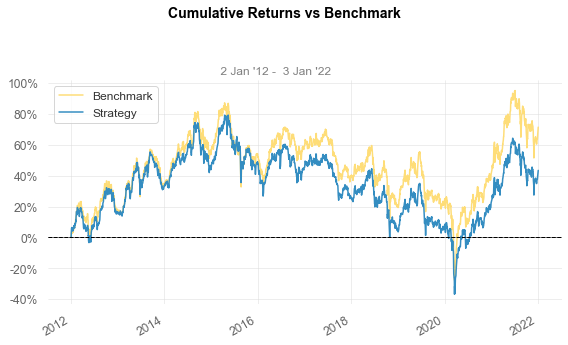

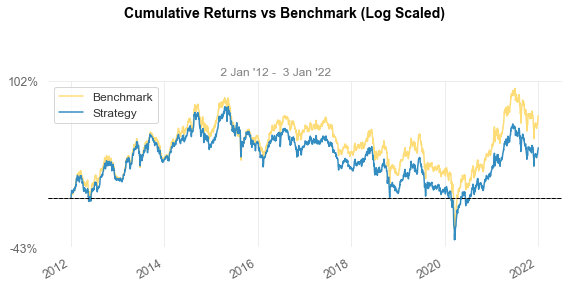

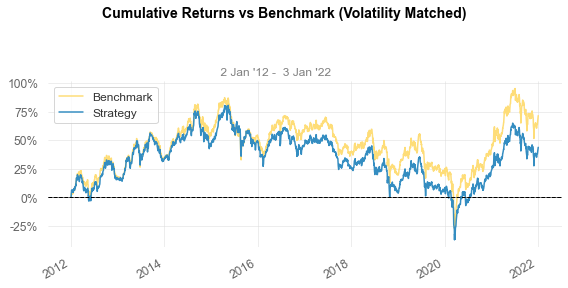

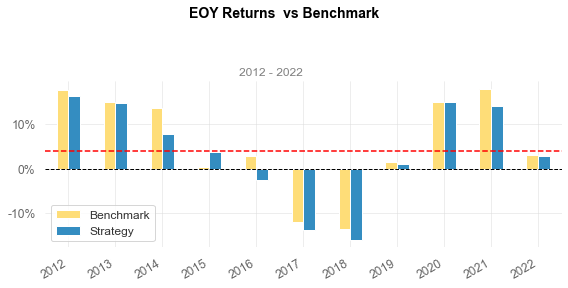

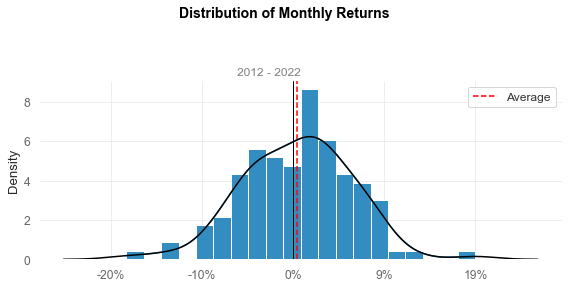

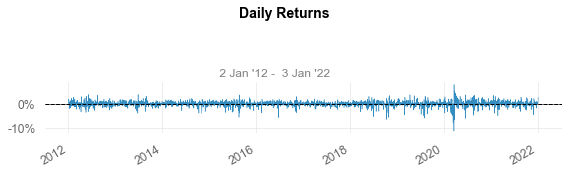

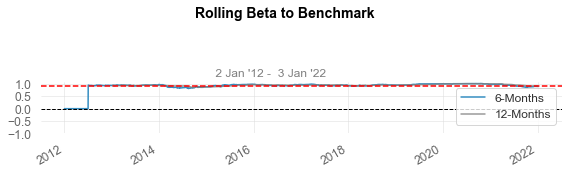

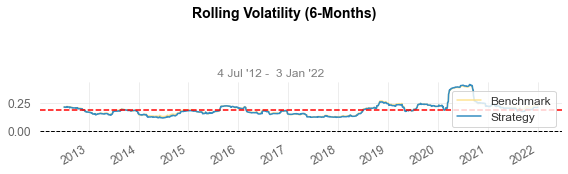

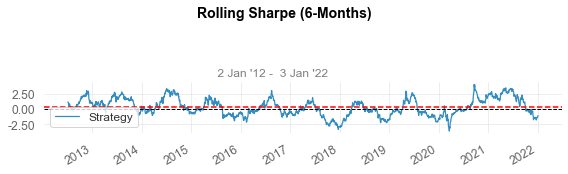

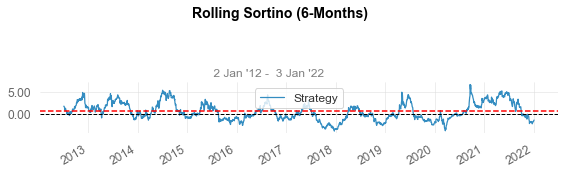

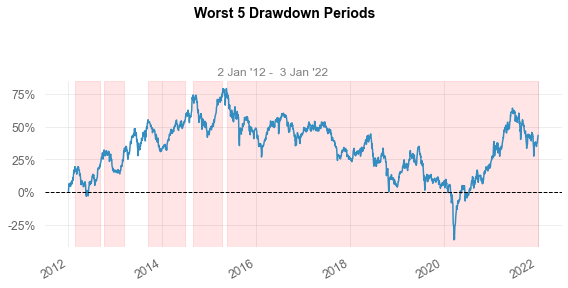

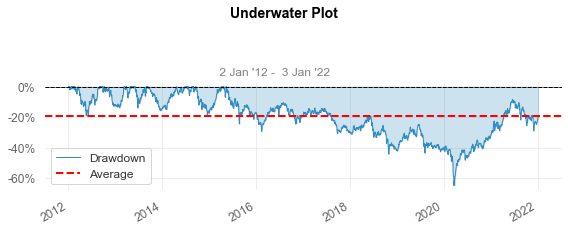

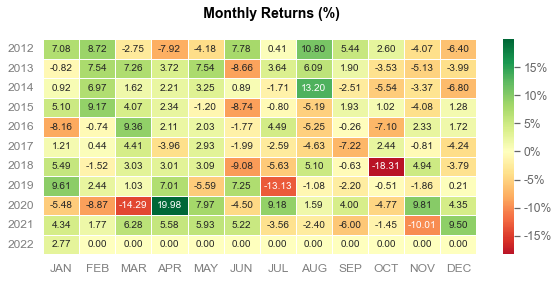

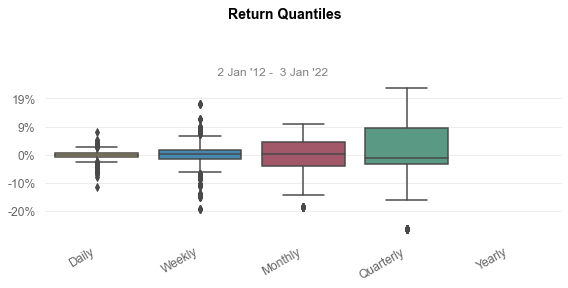

In [647]:
# 2) value 전략 & 예측모델 X & 소형주
qs.reports.full(backtest_value_4['일변화율'],backtest_value_3['일변화율'])

                           Strategy
-------------------------  ----------
Start Period               2012-01-02
End Period                 2022-01-03
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          2,507.10%
CAGR﹪                     38.5%

Sharpe                     1.62
Prob. Sharpe Ratio         100.0%
Smart Sharpe               1.43
Sortino                    2.29
Smart Sortino              2.01
Sortino/√2                 1.62
Smart Sortino/√2           1.42
Omega                      1.34

Max Drawdown               -36.0%
Longest DD Days            356
Volatility (ann.)          22.05%
Calmar                     1.07
Skew                       -0.72
Kurtosis                   6.67

Expected Daily %           0.13%
Expected Monthly %         2.73%
Expected Yearly %          34.51%
Kelly Criterion            15.06%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.14%
Expected Shortfall (cVaR)  -2.14%

Max Consecutive Wins  

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-02-21  2020-03-19  2020-04-22    61    -35.996895        -33.648427
2  2018-04-18  2018-10-29  2019-04-09   356    -30.052493        -25.220965
3  2015-07-22  2015-08-24  2016-04-19   272    -25.602982        -21.590694
4  2013-05-30  2013-06-25  2014-04-02   307    -20.662415        -14.705609
5  2019-07-15  2019-08-06  2020-01-22   191    -19.074178        -16.094370

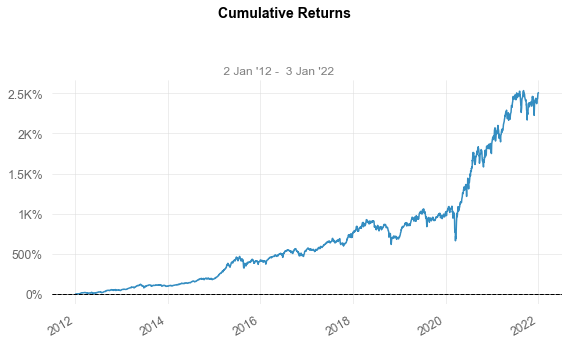

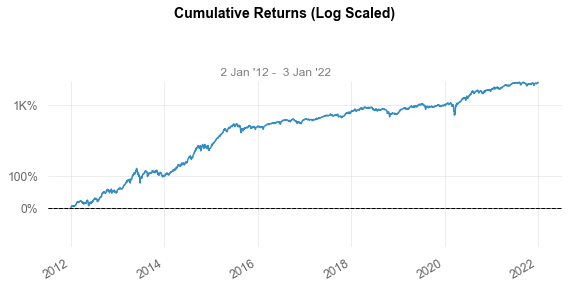

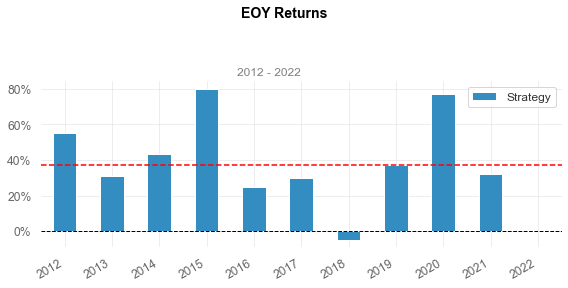

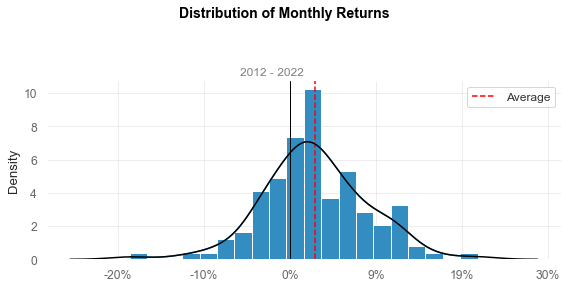

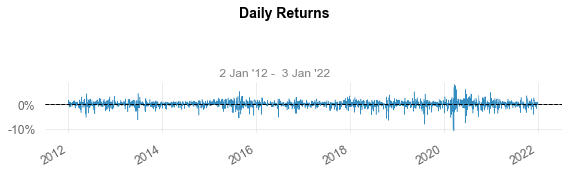

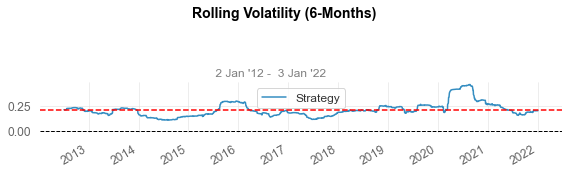

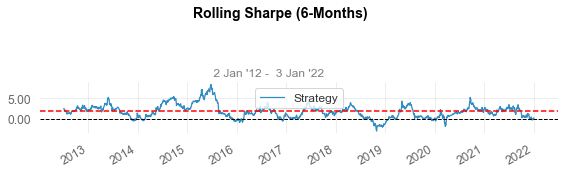

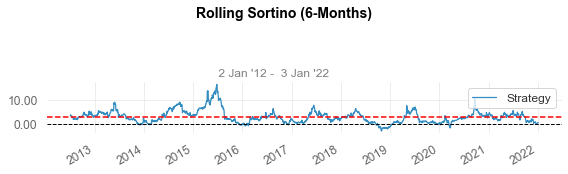

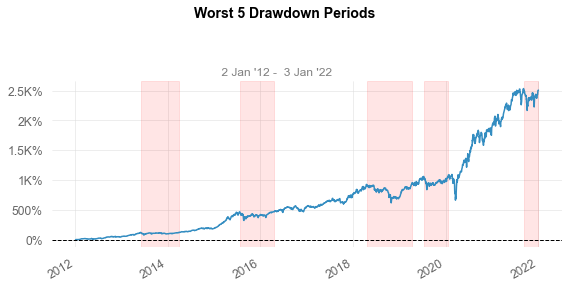

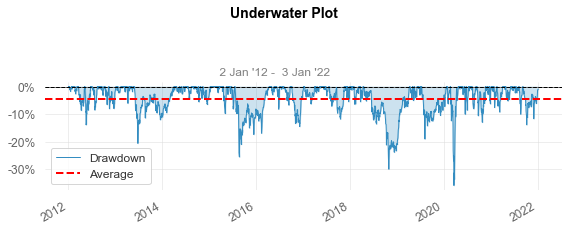

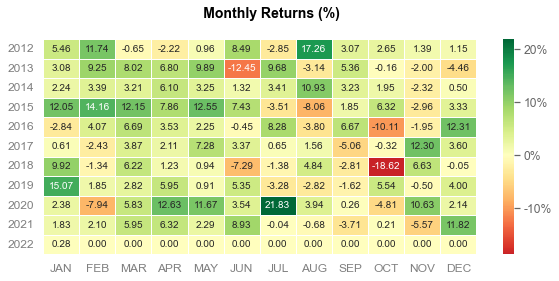

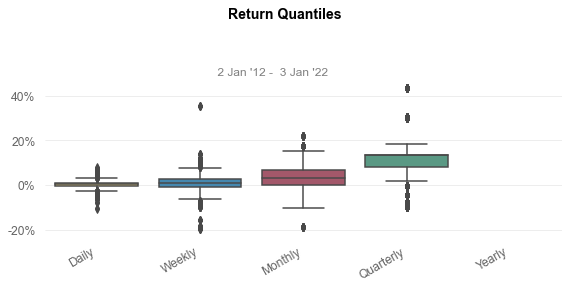

In [370]:
# 3) quality 전략 & 예측모델 X
qs.reports.full(backtest_quality_2['일변화율'],backtest_quality_1['일변화율'])

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-02  2012-01-02
End Period                 2022-01-03  2022-01-03
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          1,630.54%   1,730.94%
CAGR﹪                     32.95%      33.7%

Sharpe                     1.36        1.45
Prob. Sharpe Ratio         100.0%      100.0%
Smart Sharpe               1.19        1.27
Sortino                    1.94        2.04
Smart Sortino              1.7         1.78
Sortino/√2                 1.37        1.44
Smart Sortino/√2           1.2         1.26
Omega                      1.28        1.28

Max Drawdown               -34.65%     -36.09%
Longest DD Days            426         356
Volatility (ann.)          23.44%      22.2%
R^2                        0.9         0.9
Information Ratio          -0.0        -0.0
Calmar                     0.95       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-01-29  2020-03-19  2020-03-31    62    -34.648183        -31.973251
2  2015-07-22  2015-08-24  2016-09-20   426    -26.669178        -24.607004
3  2018-05-25  2018-10-29  2019-04-01   311    -26.356034        -21.622127
4  2019-07-12  2019-08-06  2020-01-20   192    -20.414242        -17.233718
5  2013-05-29  2013-06-25  2014-04-03   309    -20.305734        -14.400856

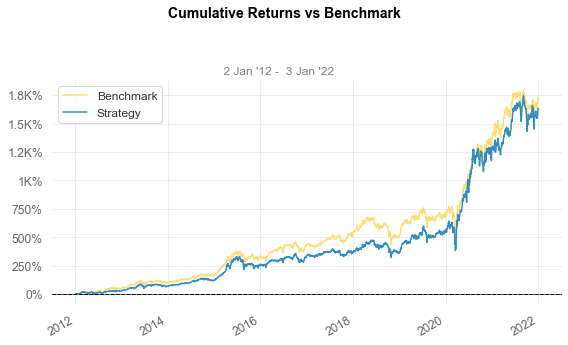

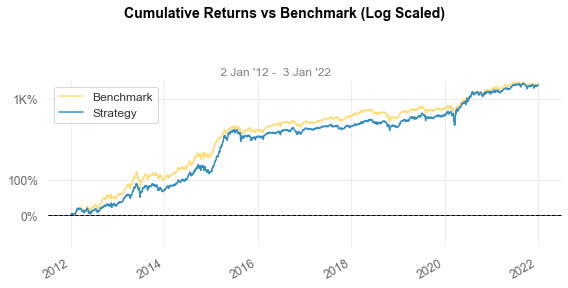

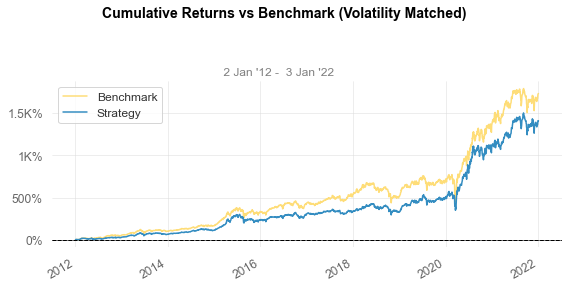

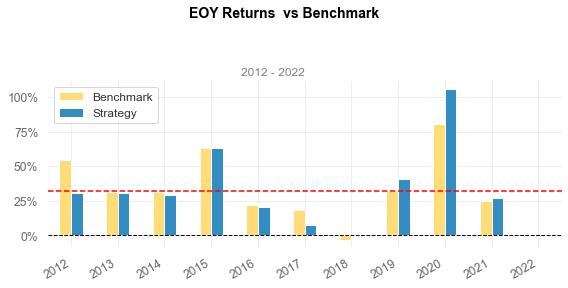

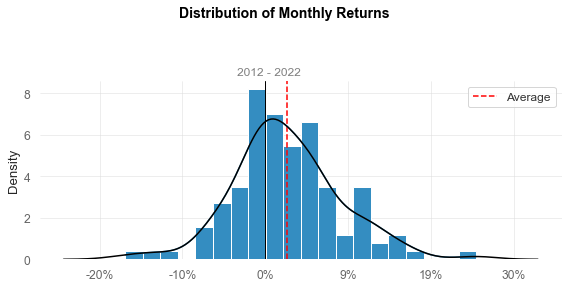

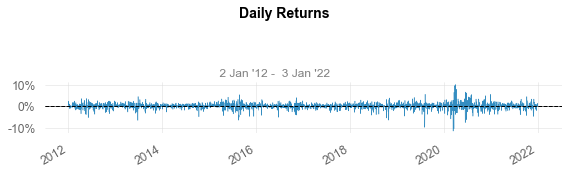

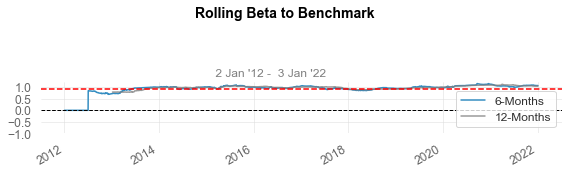

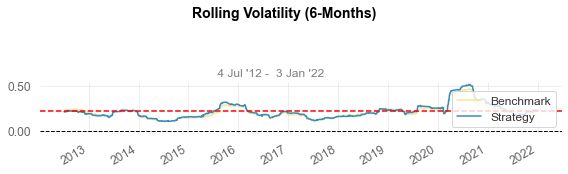

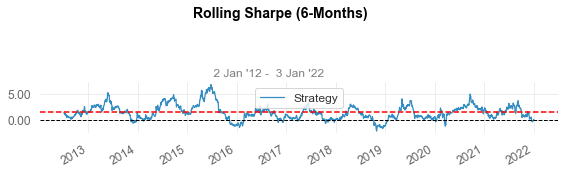

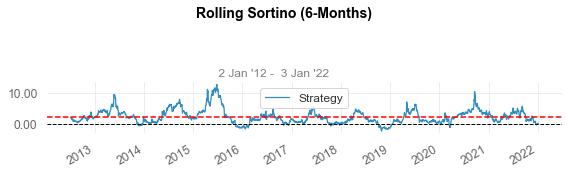

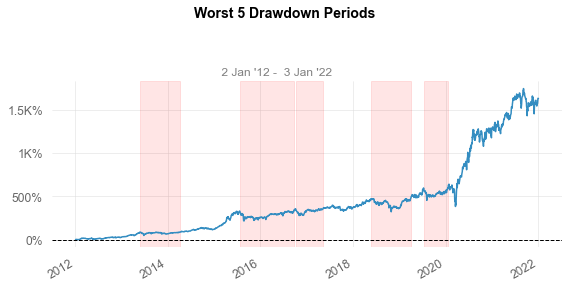

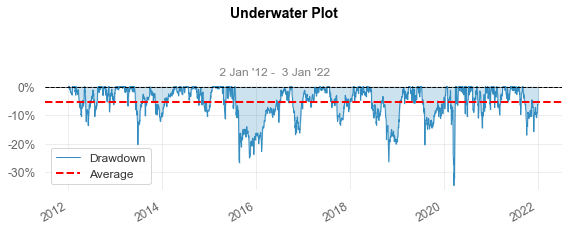

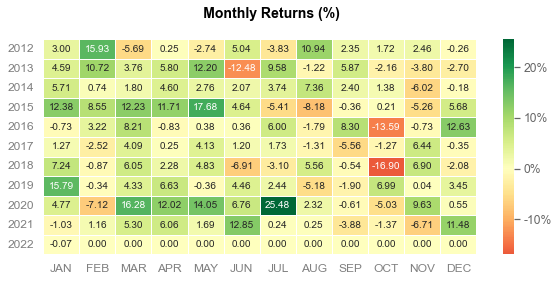

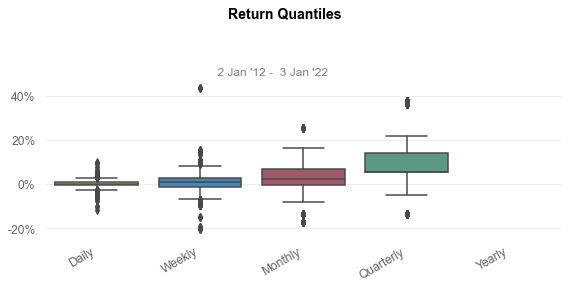

In [646]:
# 4) quality 전략 & 예측모델 X & 소형주
qs.reports.full(backtest_quality_4['일변화율'],backtest_quality_3['일변화율'])

                           Strategy
-------------------------  ----------
Start Period               2012-01-02
End Period                 2022-01-03
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          479.17%
CAGR﹪                     19.18%

Sharpe                     0.88
Prob. Sharpe Ratio         99.62%
Smart Sharpe               0.78
Sortino                    1.2
Smart Sortino              1.07
Sortino/√2                 0.85
Smart Sortino/√2           0.76
Omega                      1.17

Max Drawdown               -51.52%
Longest DD Days            467
Volatility (ann.)          23.68%
Calmar                     0.37
Skew                       -0.91
Kurtosis                   7.69

Expected Daily %           0.07%
Expected Monthly %         1.46%
Expected Yearly %          17.31%
Kelly Criterion            7.98%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.37%
Expected Shortfall (cVaR)  -2.37%

Max Consecutive Wins    

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2019-06-21  2020-03-23  2020-09-10   447    -51.521959        -44.584491
2  2018-05-24  2018-10-29  2019-06-07   379    -31.750953        -27.151003
3  2015-06-25  2016-02-12  2016-10-04   467    -29.471822        -25.922062
4  2021-06-29  2021-11-30  2022-01-03   188    -25.907398        -23.084686
5  2012-09-11  2012-12-11  2013-03-12   182    -22.248280        -22.118119

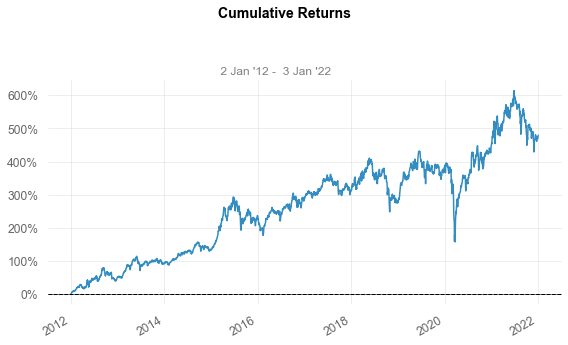

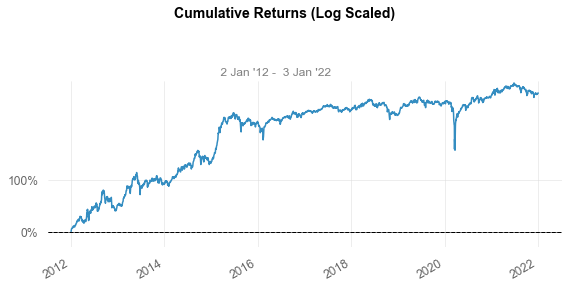

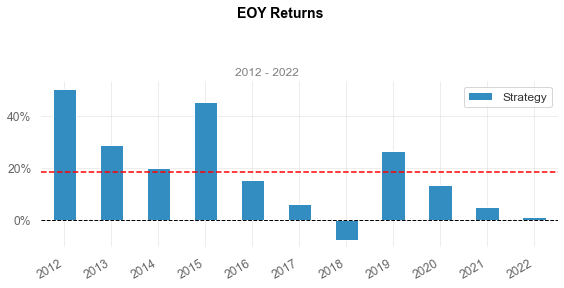

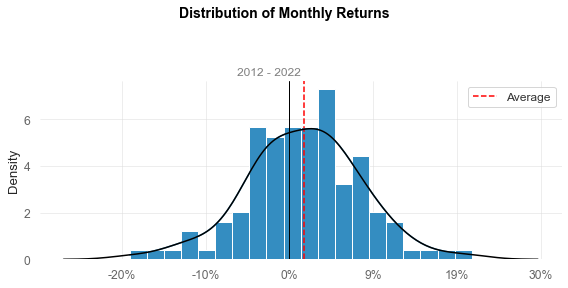

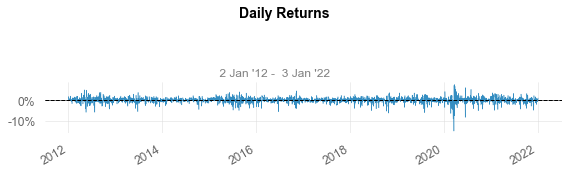

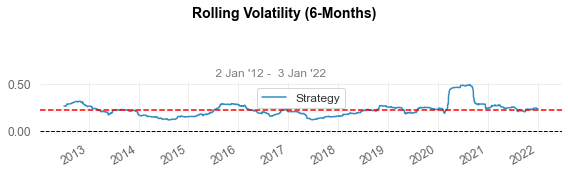

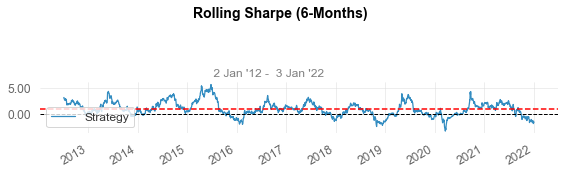

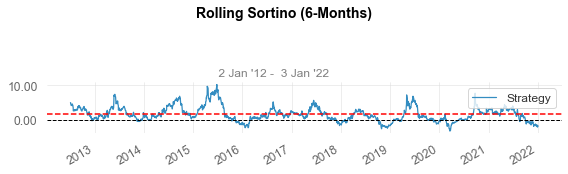

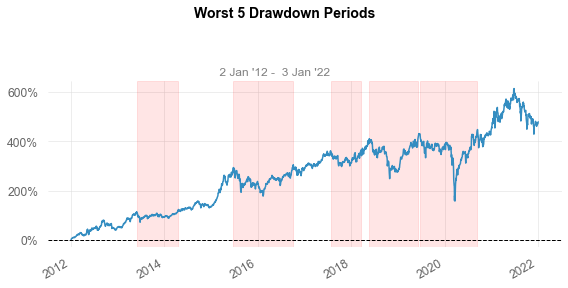

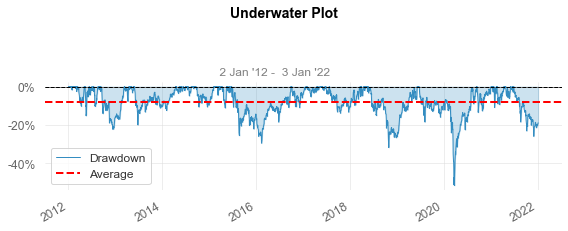

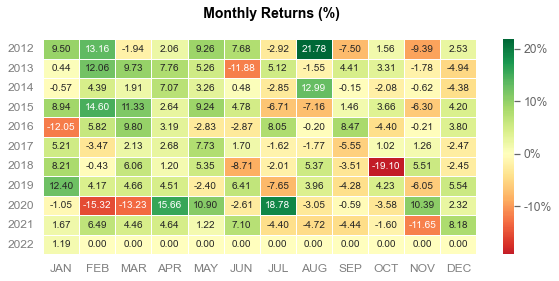

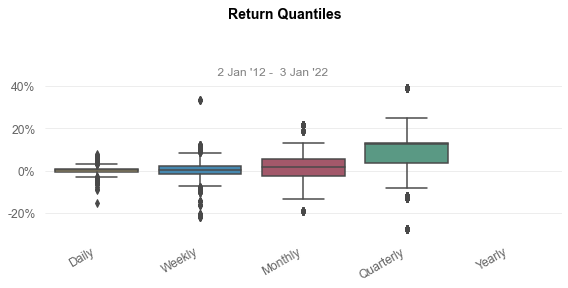

In [373]:
# 5) value &quality 전략 & 예측모델 X
qs.reports.full(backtest_valquality_2['일변화율'],backtest_valquality_1['일변화율'])

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-02  2012-01-02
End Period                 2022-01-03  2022-01-03
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          703.74%     478.1%
CAGR﹪                     23.14%      19.16%

Sharpe                     1.03        0.89
Prob. Sharpe Ratio         99.92%      99.66%
Smart Sharpe               0.94        0.82
Sortino                    1.43        1.22
Smart Sortino              1.31        1.12
Sortino/√2                 1.01        0.86
Smart Sortino/√2           0.93        0.79
Omega                      1.2         1.2

Max Drawdown               -30.72%     -48.8%
Longest DD Days            321         460
Volatility (ann.)          23.46%      23.28%
R^2                        0.66        0.66
Information Ratio          0.01        0.01
Calmar                     0.75        0

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-02-24  2020-03-23  2020-04-06    42    -30.723859        -29.671143
2  2018-05-24  2018-10-29  2019-02-14   266    -27.407739        -23.544491
3  2020-08-04  2020-12-28  2021-06-14   314    -23.245692        -22.301710
4  2021-09-08  2021-11-30  2022-01-03   117    -22.506429        -20.275029
5  2015-07-17  2015-08-24  2016-04-07   265    -22.353547        -19.949171

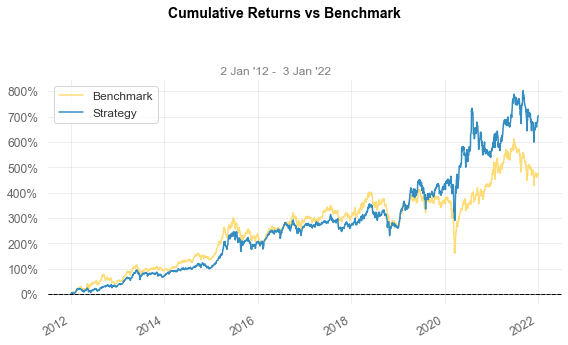

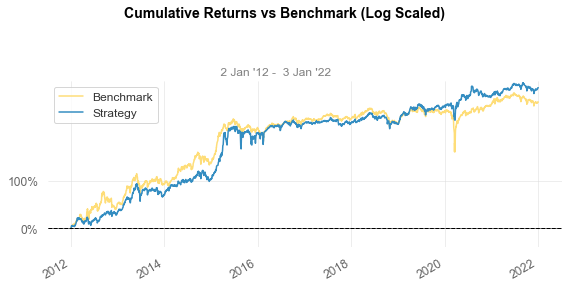

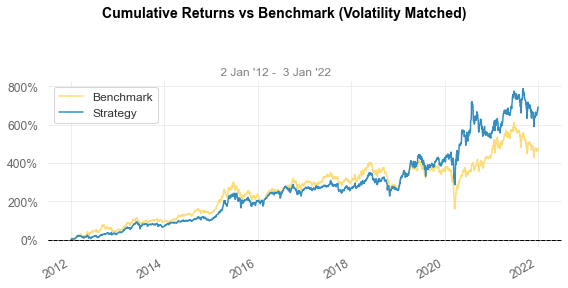

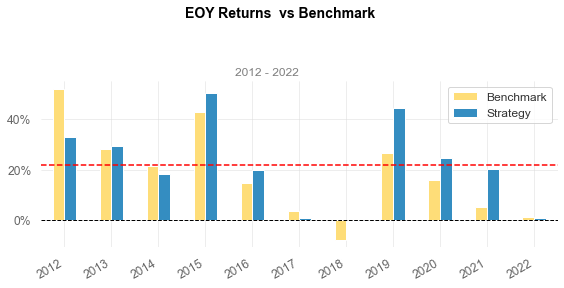

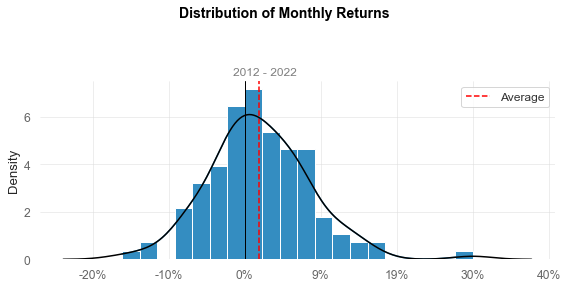

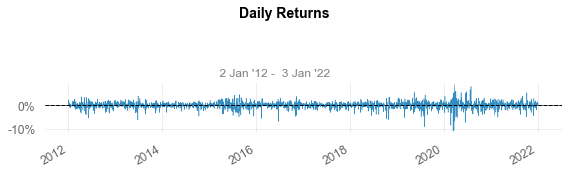

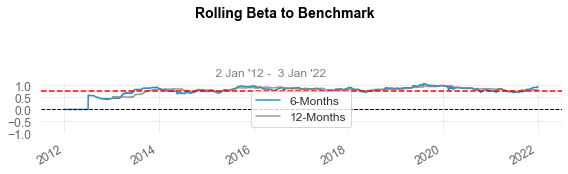

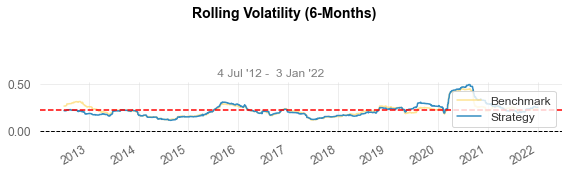

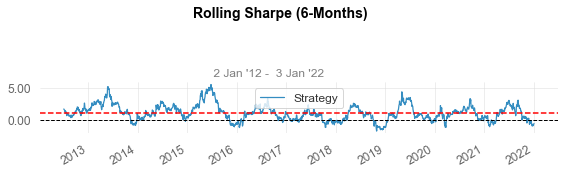

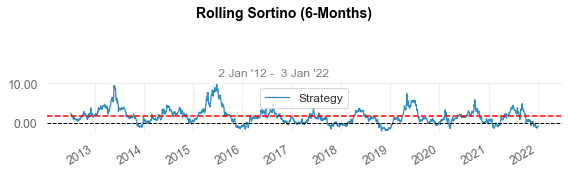

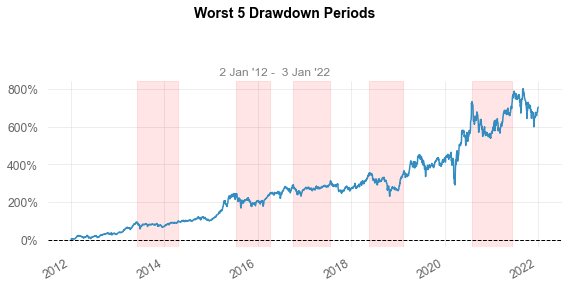

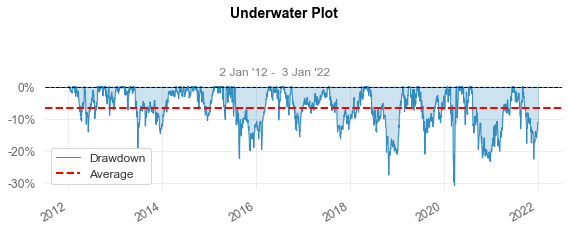

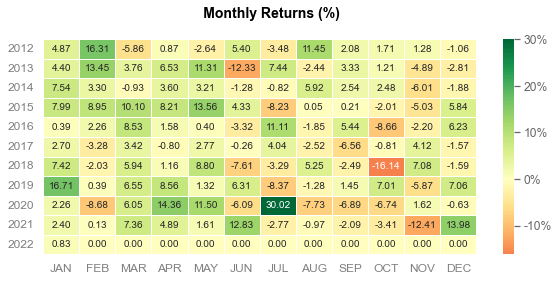

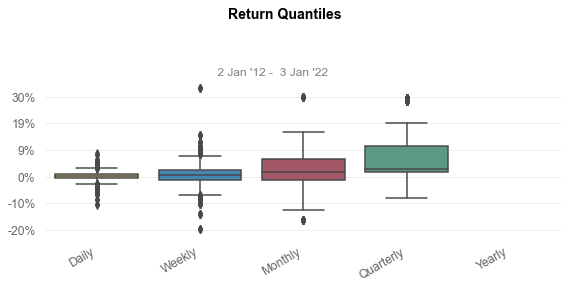

In [648]:
# 6) value &quality 전략 & 예측모델 X & 소형주
qs.reports.full(backtest_valquality_4['일변화율'],backtest_valquality_3['일변화율'])

                           Strategy
-------------------------  ----------
Start Period               2012-01-02
End Period                 2022-01-03
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -72.74%
CAGR﹪                     -12.18%

Sharpe                     -0.28
Prob. Sharpe Ratio         18.67%
Smart Sharpe               -0.27
Sortino                    -0.38
Smart Sortino              -0.36
Sortino/√2                 -0.27
Smart Sortino/√2           -0.25
Omega                      0.95

Max Drawdown               -86.51%
Longest DD Days            3652
Volatility (ann.)          30.43%
Calmar                     -0.14
Skew                       -0.42
Kurtosis                   3.11

Expected Daily %           -0.05%
Expected Monthly %         -1.07%
Expected Yearly %          -11.15%
Kelly Criterion            -2.56%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.19%
Expected Shortfall (cVaR)  -3.19%

Max Consec

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2012-01-04  2020-03-19  2022-01-03  3652    -86.510167        -79.660601

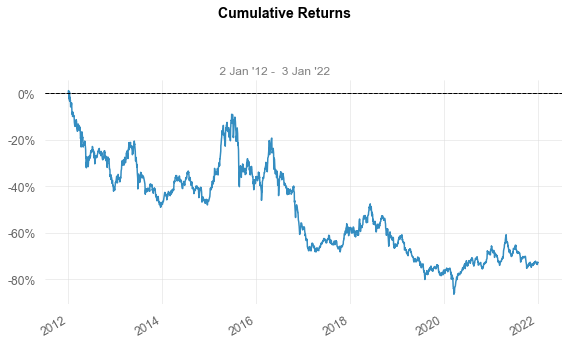

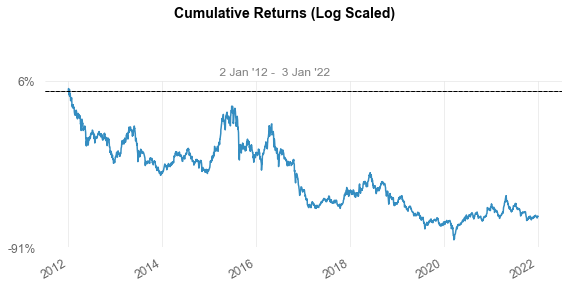

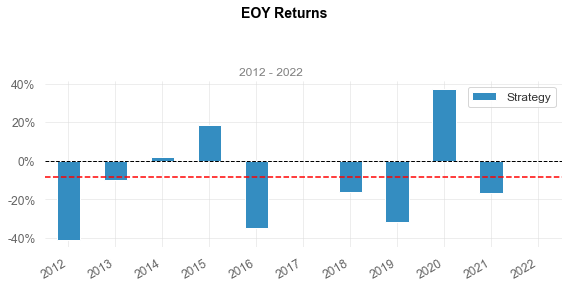

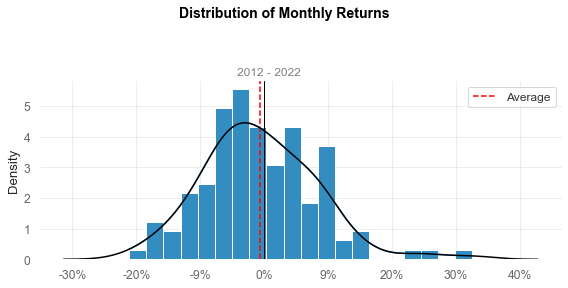

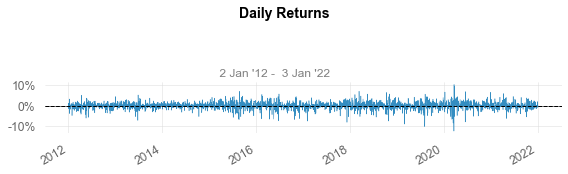

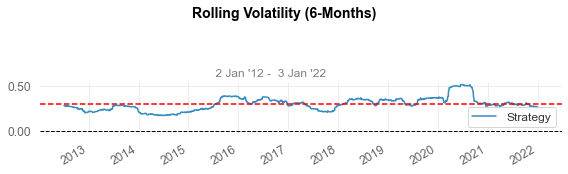

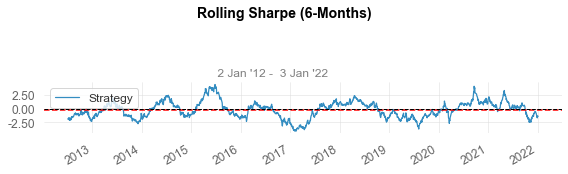

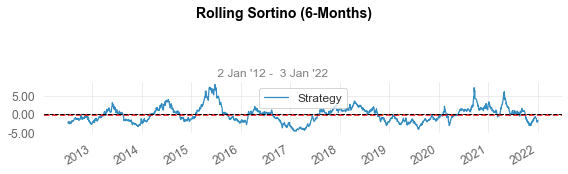

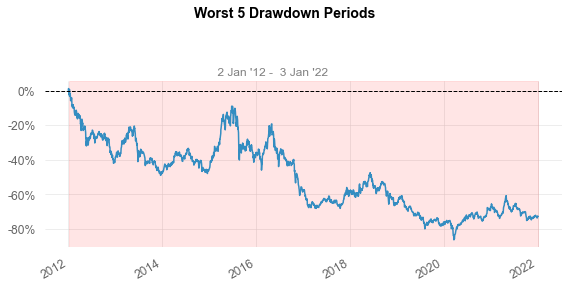

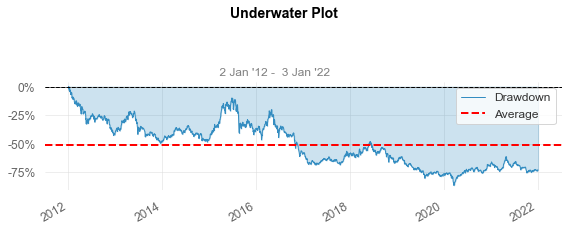

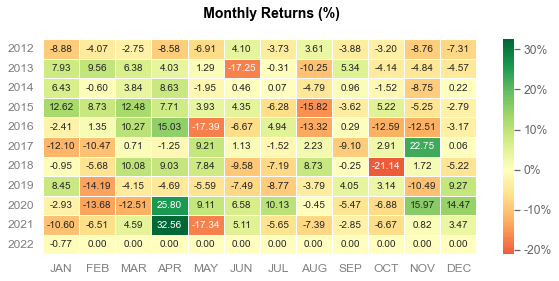

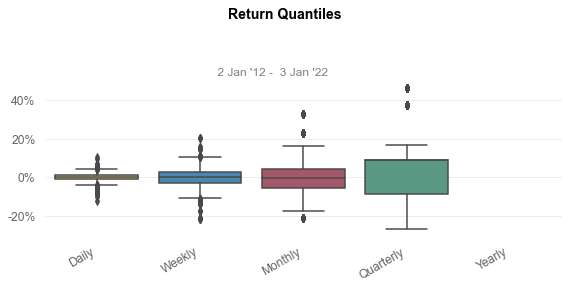

In [137]:
# 7) momentum 전략 & 예측모델 X
qs.reports.full(backtest_momentum_1['일변화율'])

                           Strategy
-------------------------  ----------
Start Period               2012-01-02
End Period                 2022-01-03
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -66.98%
CAGR﹪                     -10.48%

Sharpe                     -0.23
Prob. Sharpe Ratio         23.12%
Smart Sharpe               -0.21
Sortino                    -0.31
Smart Sortino              -0.29
Sortino/√2                 -0.22
Smart Sortino/√2           -0.2
Omega                      0.96

Max Drawdown               -87.03%
Longest DD Days            3652
Volatility (ann.)          29.57%
Calmar                     -0.12
Skew                       -0.37
Kurtosis                   3.53

Expected Daily %           -0.04%
Expected Monthly %         -0.91%
Expected Yearly %          -9.58%
Kelly Criterion            -2.15%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.09%
Expected Shortfall (cVaR)  -3.09%

Max Consecut

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2012-01-04  2020-03-19  2022-01-03  3652    -87.026253        -82.520312

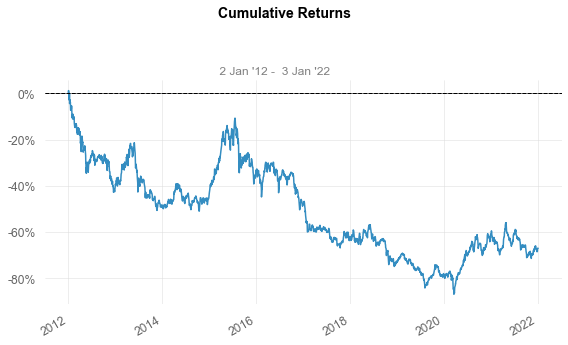

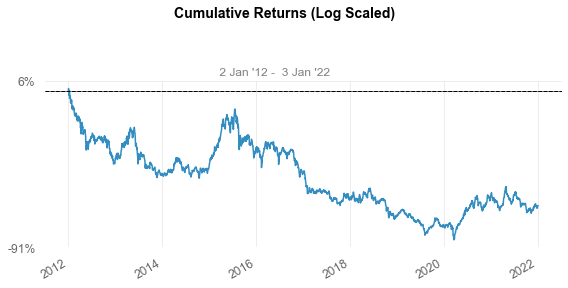

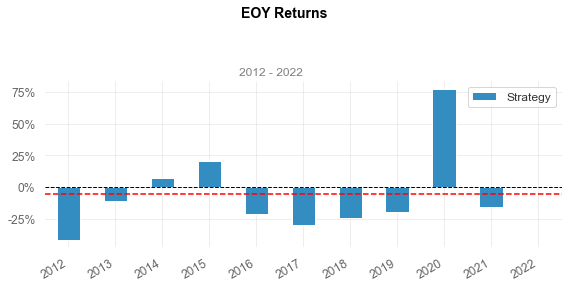

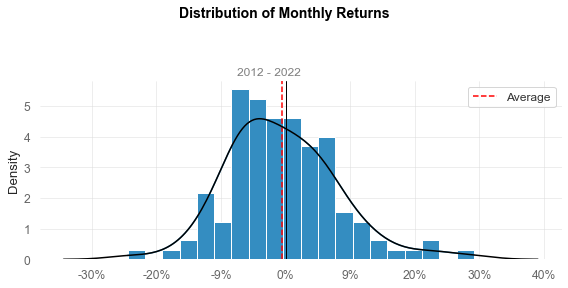

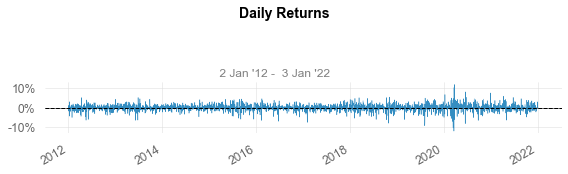

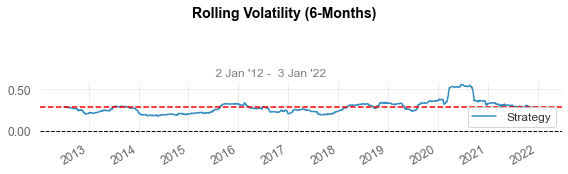

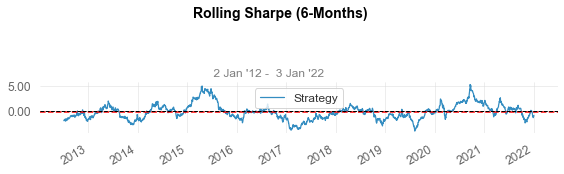

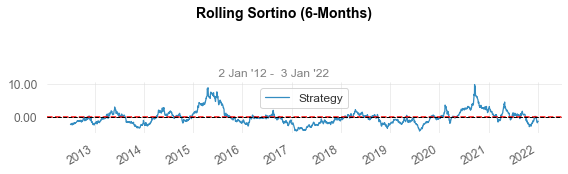

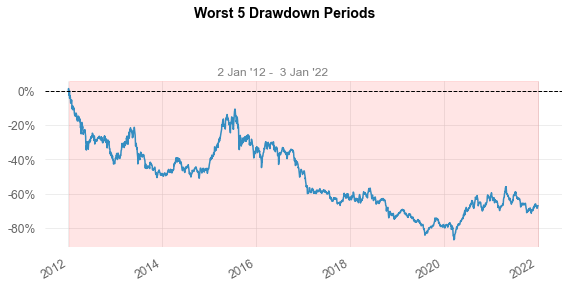

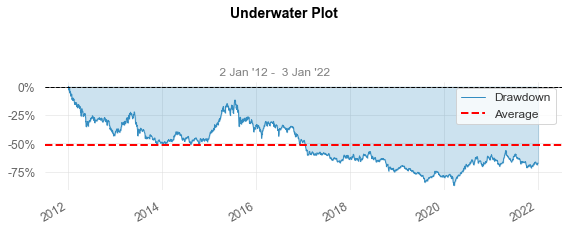

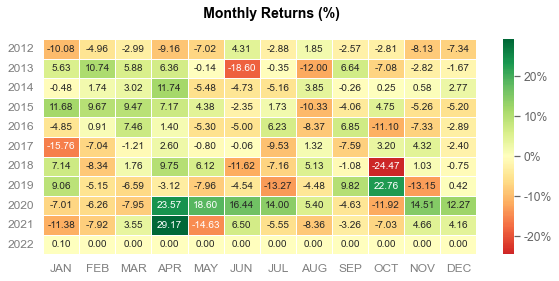

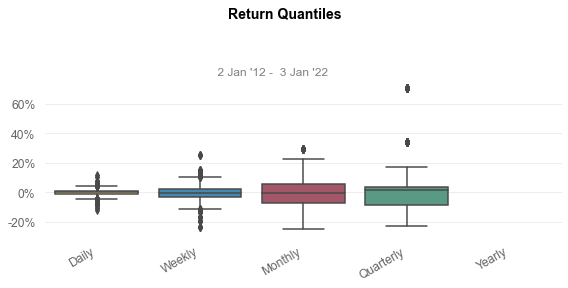

In [138]:
# 8) momentum 전략 & 예측모델 O
qs.reports.full(backtest_momentum_2['일변화율'])

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-02  2012-01-02
End Period                 2022-01-03  2022-01-03
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          -66.98%     -73.08%
CAGR﹪                     -10.48%     -12.29%

Sharpe                     -0.23       -0.29
Prob. Sharpe Ratio         23.12%      18.31%
Smart Sharpe               -0.21       -0.26
Sortino                    -0.31       -0.39
Smart Sortino              -0.29       -0.35
Sortino/√2                 -0.22       -0.27
Smart Sortino/√2           -0.2        -0.25
Omega                      0.96        0.96

Max Drawdown               -87.03%     -86.51%
Longest DD Days            3652        3652
Volatility (ann.)          29.57%      30.42%
R^2                        0.73        0.73
Information Ratio          0.01        0.01
Calmar                     -0

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2012-01-04  2020-03-19  2022-01-03  3652    -87.026253        -82.520312

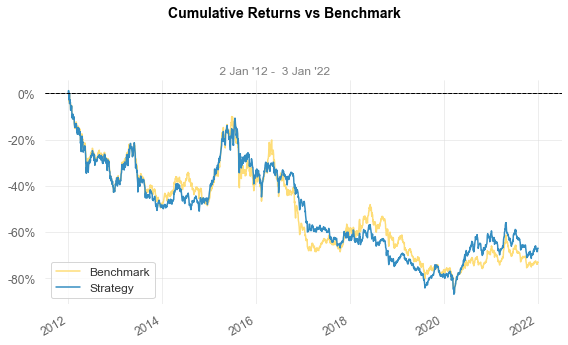

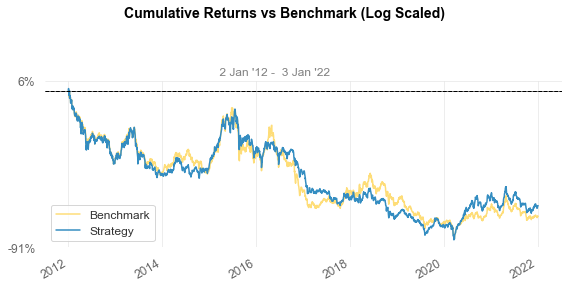

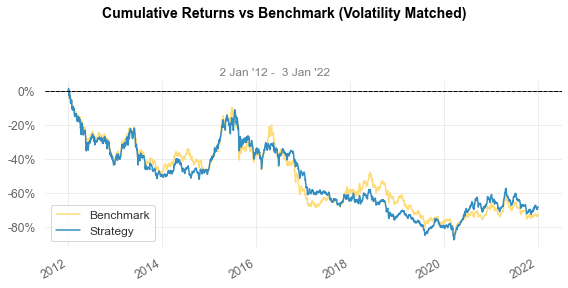

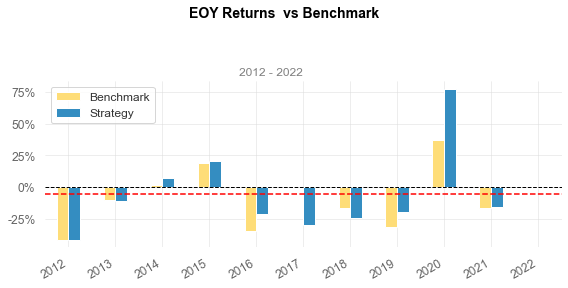

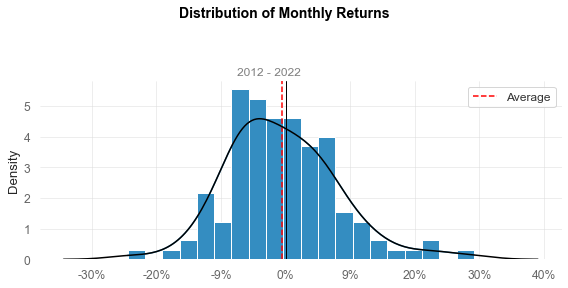

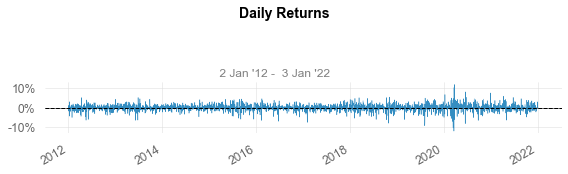

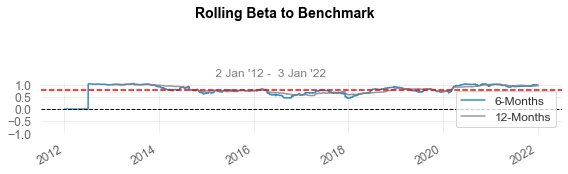

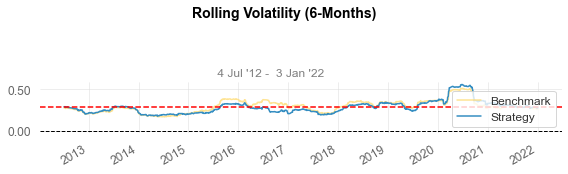

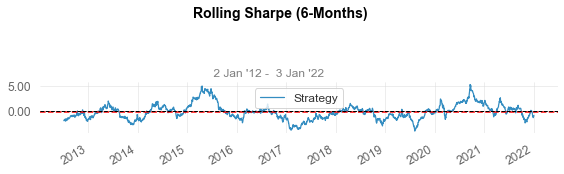

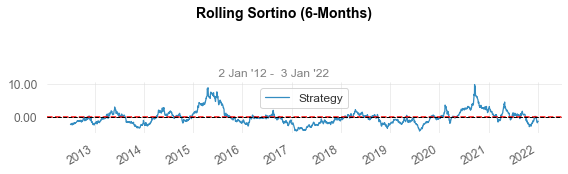

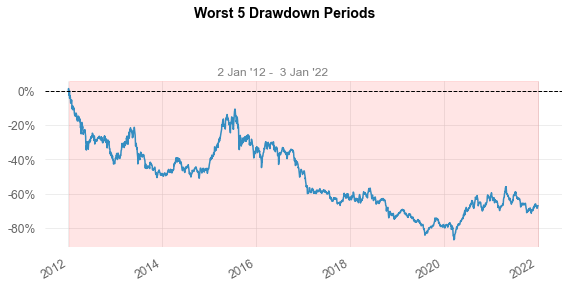

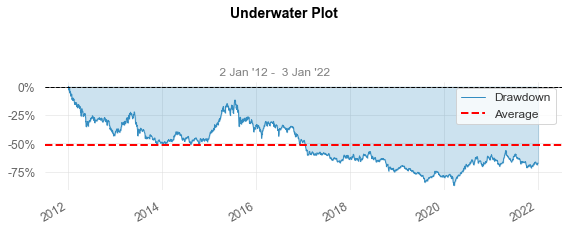

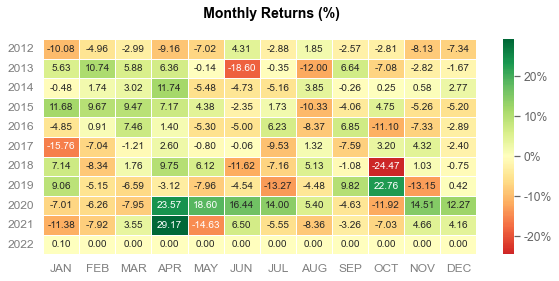

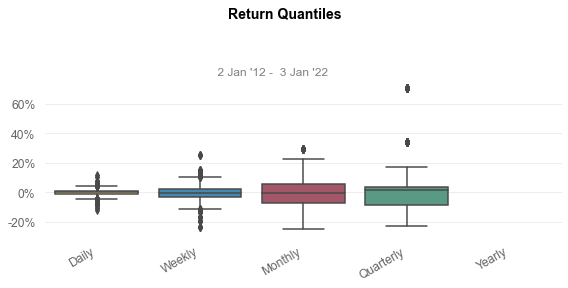

In [494]:
# 9) 모멘텀 성과비교
qs.reports.full(backtest_momentum_2['일변화율'],backtest_momentum_1['일변화율'])

In [ ]:
# 9-2) 모멘텀 비교 2
qs.reports.full(backtest_momentum_4['일변화율'],backtest_momentum_3['일변화율'])

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-02  2012-01-02
End Period                 2022-01-03  2022-01-03
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          203.04%     178.55%
CAGR﹪                     11.71%      10.78%

Sharpe                     0.68        0.69
Prob. Sharpe Ratio         98.25%      98.54%
Smart Sharpe               0.6         0.61
Sortino                    0.96        1.05
Smart Sortino              0.85        0.93
Sortino/√2                 0.68        0.74
Smart Sortino/√2           0.6         0.66
Omega                      1.13        1.13

Max Drawdown               -41.63%     -39.06%
Longest DD Days            929         869
Volatility (ann.)          19.49%      17.26%
R^2                        0.28        0.28
Information Ratio          0.0         0.0
Calmar                     0.28       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2019-06-19  2020-03-19  2022-01-03   929    -41.633689        -35.968481
2  2018-05-31  2018-10-29  2019-06-18   383    -27.828305        -23.061629
3  2015-07-27  2015-08-21  2015-10-21    86    -20.145151        -19.351861
4  2015-11-30  2016-02-12  2016-04-19   141    -19.047620        -16.037316
5  2017-01-09  2017-09-26  2018-05-14   490    -18.255430        -16.522032

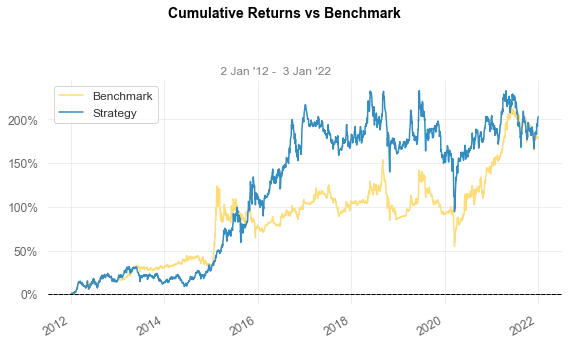

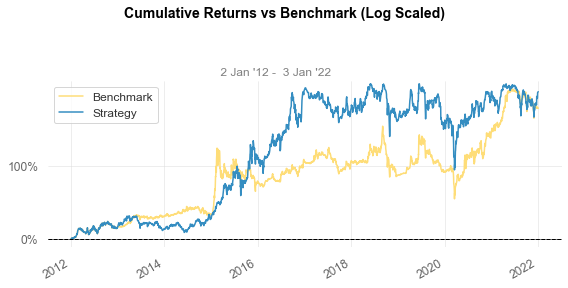

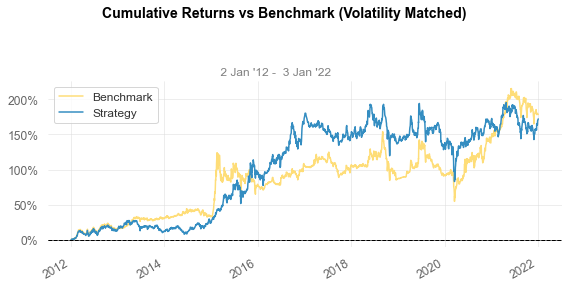

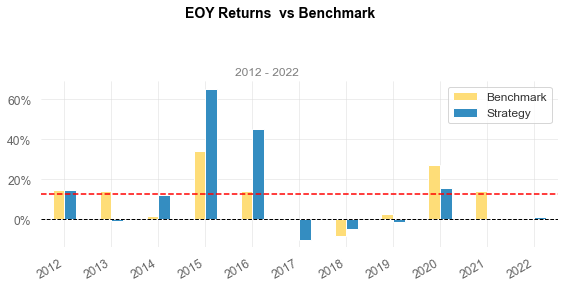

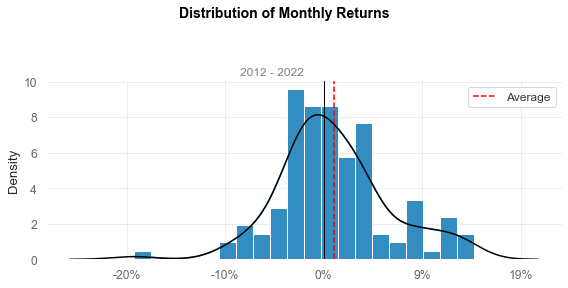

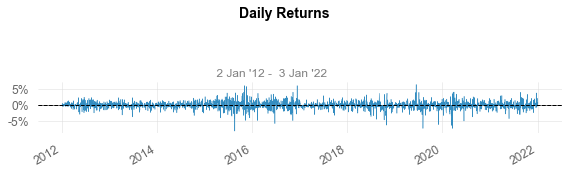

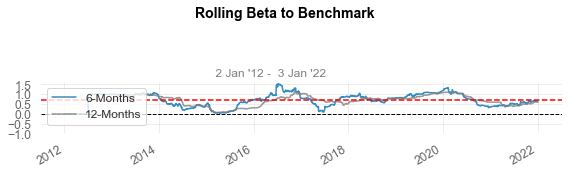

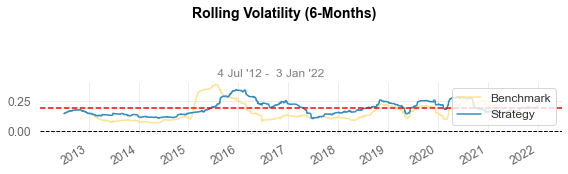

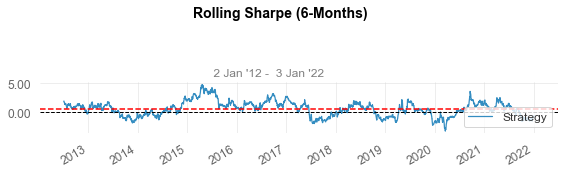

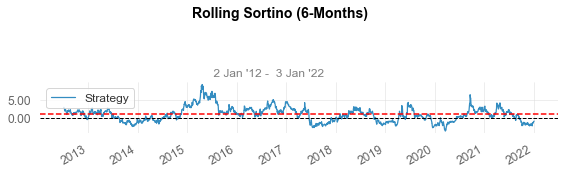

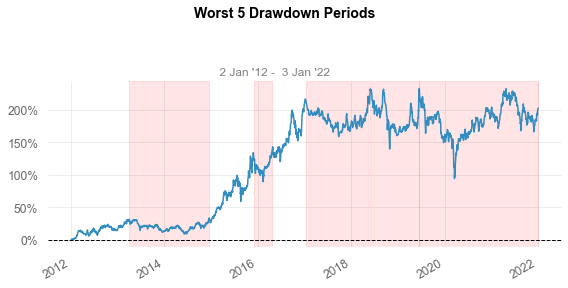

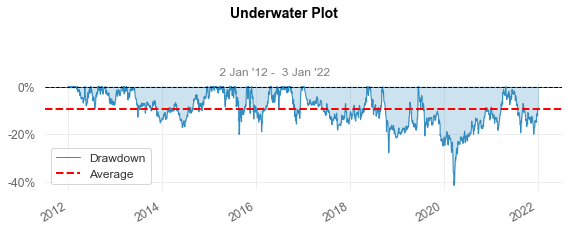

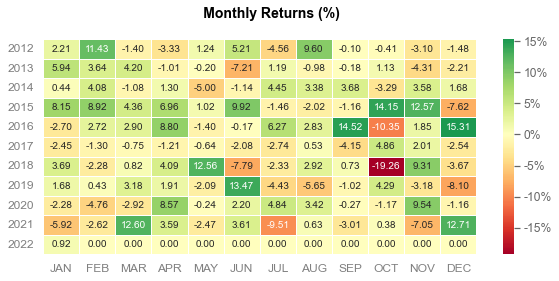

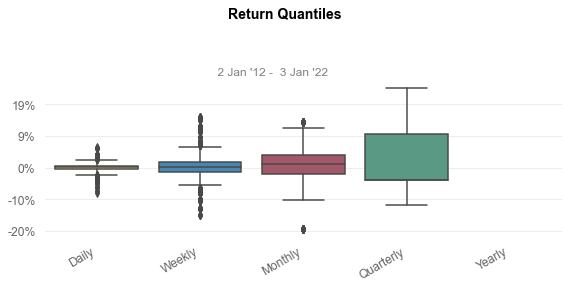

In [661]:
# 10) 로우볼 비교
qs.reports.full(backtest_lowvol_2['일변화율'],backtest_lowvol_1['일변화율'])

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-02  2012-01-02
End Period                 2022-01-03  2022-01-03
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          203.04%     178.55%
CAGR﹪                     11.71%      10.78%

Sharpe                     0.68        0.69
Prob. Sharpe Ratio         98.25%      98.54%
Smart Sharpe               0.6         0.61
Sortino                    0.96        1.05
Smart Sortino              0.85        0.93
Sortino/√2                 0.68        0.74
Smart Sortino/√2           0.6         0.66
Omega                      1.13        1.13

Max Drawdown               -41.63%     -39.06%
Longest DD Days            929         869
Volatility (ann.)          19.49%      17.26%
R^2                        0.28        0.28
Information Ratio          0.0         0.0
Calmar                     0.28       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2019-06-19  2020-03-19  2022-01-03   929    -41.633689        -35.968481
2  2018-05-31  2018-10-29  2019-06-18   383    -27.828305        -23.061629
3  2015-07-27  2015-08-21  2015-10-21    86    -20.145151        -19.351861
4  2015-11-30  2016-02-12  2016-04-19   141    -19.047620        -16.037316
5  2017-01-09  2017-09-26  2018-05-14   490    -18.255430        -16.522032

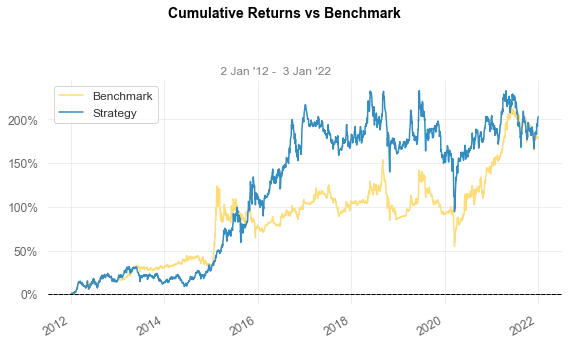

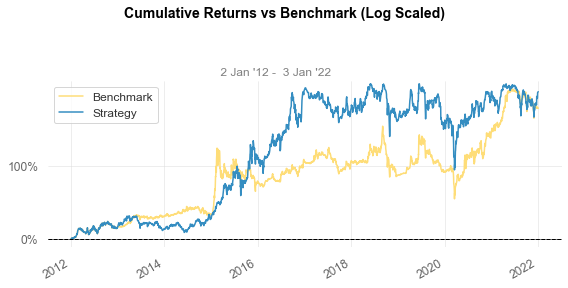

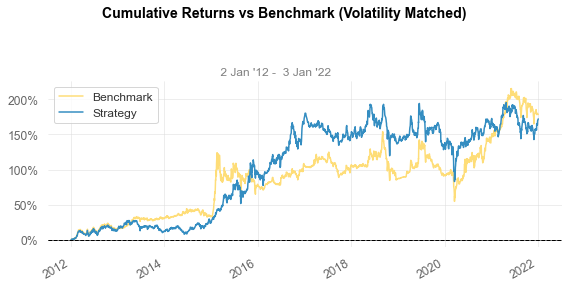

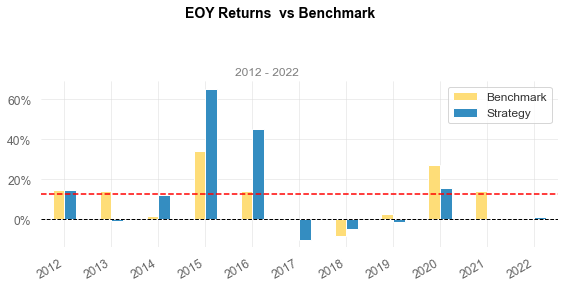

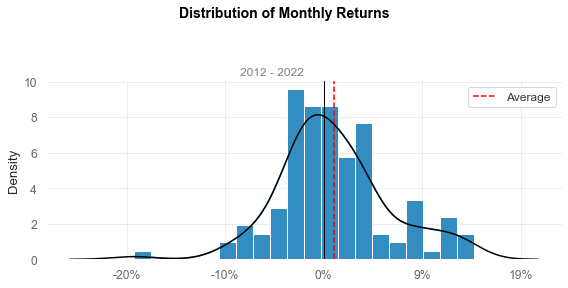

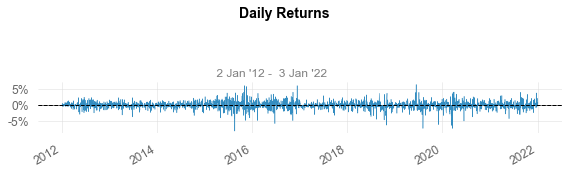

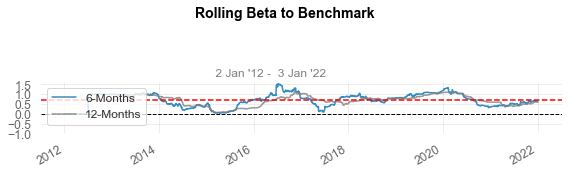

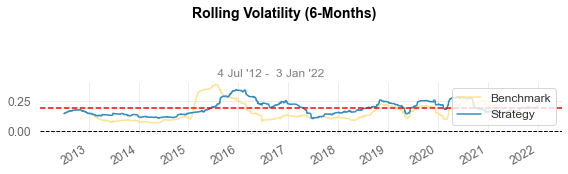

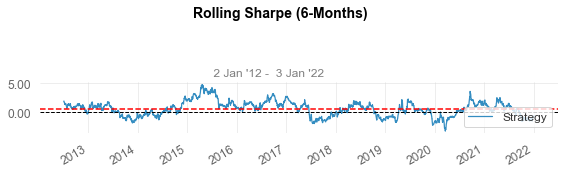

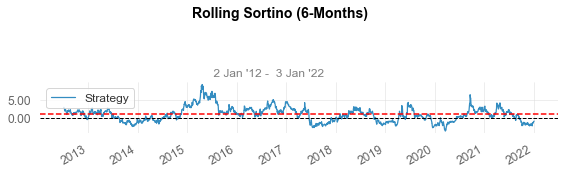

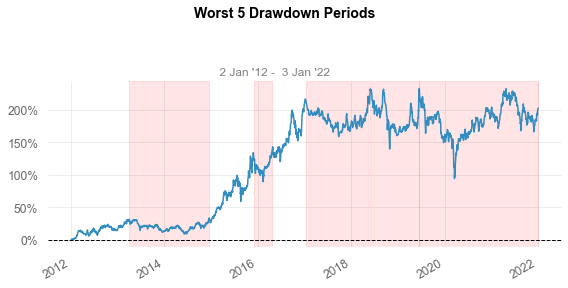

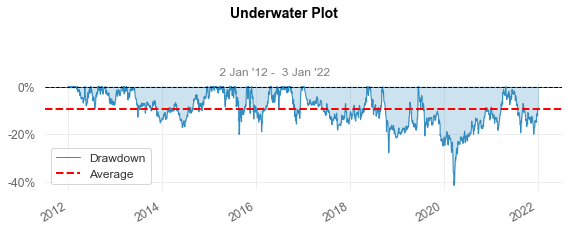

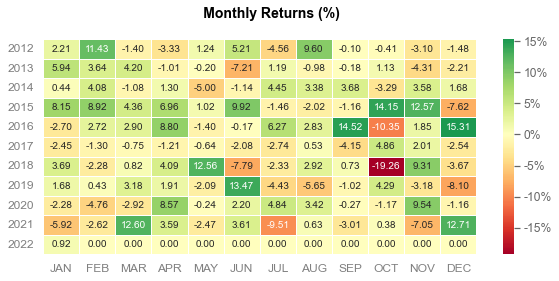

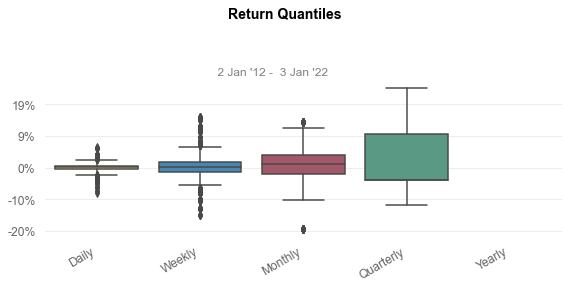

In [662]:
# 10-2) 로우볼 비교 2
qs.reports.full(backtest_lowvol_4['일변화율'],backtest_lowvol_3['일변화율'])